# 1. Imports

In [116]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime

from math import floor



# 2. Settings

In [3]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
plt.style.use('ggplot')
RANDOM_SEED = 0

# 3. Loading Data

In [4]:
def read_transport_data(filename):
    types_mapping = {
        'Numer / oznaczenie linii' : str,                                     
        'Wariant linii' : str,                                              
        'Kurs' : str,                                                        
        'Oznaczenie brygady' : str,
        'Czas rzeczywisty odjazdu wg. rozkładu' : str,                              
        'Czas odjazdu z przystanku' : str,
    }

    df = pd.read_csv(filename, sep=';', dtype=types_mapping)
    df = df.drop(columns='Data')
    
    names_mapping = {
        'Numer / oznaczenie linii' : 'Nr linii',                                     
        # 'Wariant linii'                                                    
        # 'Kurs'                                                                
        # 'Oznaczenie brygady'                                                  
        # 'Numer taborowy'                                                     
        # 'Nazwa przystanku'                                                    
        # 'Numer przystanku'                                                   
        'Czas rzeczywisty odjazdu wg. rozkładu' : 'Rzeczywisty czas odjazdu',                              
        'Czas odjazdu z przystanku' : 'Rozkładowy czas odjazdu',                                      
        'Liczba pasażerów w pojeździe przed przystankiem (dane skorygowane)' : 'Liczba pasaz. przed',  
        'Liczba osób które wysiadły (dane skorygowane)' : 'Liczba wysiadających pasaz.',                       
        'Liczba osób które wsiadły (dane skorygowane)' : 'Liczba wsiadajacych pasaz.',                     
        'Liczba pasażerów w pojeździe po odjeździe (dane skorygowane)' : 'Liczba pasaz. po odjezdzie'
    }
    df.rename(columns=names_mapping, inplace=True)

    

    return df

In [5]:
df = read_transport_data('./data/SZP-2021-09-03.csv')

# 4. Inspecting Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177546 entries, 0 to 177545
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Nr linii                     177546 non-null  object
 1   Wariant linii                177546 non-null  object
 2   Kurs                         177546 non-null  object
 3   Oznaczenie brygady           177546 non-null  object
 4   Numer taborowy               177546 non-null  int64 
 5   Nazwa przystanku             177546 non-null  object
 6   Numer przystanku             177546 non-null  int64 
 7   Rzeczywisty czas odjazdu     172273 non-null  object
 8   Rozkładowy czas odjazdu      177546 non-null  object
 9   Liczba pasaz. przed          177546 non-null  int64 
 10  Liczba wysiadających pasaz.  177546 non-null  int64 
 11  Liczba wsiadajacych pasaz.   177546 non-null  int64 
 12  Liczba pasaz. po odjezdzie   177546 non-null  int64 
dtypes: int64(6), o

In [7]:
df.sample(5)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
112294,219,TP-GOC,10:08,1,9201,Gocław,4,10:35:00,10:36,8,8,0,0
110698,212,TP-CHT,21:45,3,9677,Metro Trocka,1,21:59:00,21:57:36,1,0,3,4
121116,234,TP-AUG,17:27,2,9249,Augustów,2,17:49:00,17:47,2,0,0,2
133379,516,TP-NWD,06:00,1,9420,Ekspresowa,2,06:07:00,06:07,8,1,0,7
176940,Z23,TP-NBM,21:20,8,9842,Radiowa,2,21:35:00,21:36,3,3,0,0


In [8]:
df.describe()

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
count,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000
mean,9513.375953,3.437903,12.060711,1.560435,1.570534,12.070810
std,265.044802,7.857952,12.341741,3.136487,3.192504,12.335713
min,9061.000000,1.000000,-3.000000,0.000000,0.000000,0.000000
25%,9319.000000,1.000000,4.000000,0.000000,0.000000,4.000000
50%,9452.000000,2.000000,9.000000,0.000000,0.000000,9.000000
75%,9806.000000,3.000000,16.000000,2.000000,2.000000,16.000000
max,9955.000000,88.000000,133.000000,124.000000,110.000000,133.000000


# 4.1. Check data

In [9]:
counter = 0
counter += len(df.loc[df['Liczba pasaz. przed'] - df['Liczba wysiadających pasaz.'] + df['Liczba wsiadajacych pasaz.'] != df['Liczba pasaz. po odjezdzie']])
counter += len(df[df['Liczba pasaz. przed'] < 0])
print(f'Amount of invalid data: {counter}')

Amount of invalid data: 2


# 4.2. Remove errors

In [10]:
df.drop(df[df['Liczba pasaz. przed'] < 0].index, inplace=True) # remove invlid amout of passengers

df.drop(df[df['Kurs'].str[:2] > '23'].index, inplace= True)

is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

df.drop(df[row_has_NaN].index, inplace=True)


# 4.3. Parse data

In [11]:
def make_date_one_type(x):
    return pd.Timestamp(x)

In [12]:
df['Kurs'] = df['Kurs'].apply(lambda x: make_date_one_type(x))
df['Rzeczywisty czas odjazdu'] = df['Rzeczywisty czas odjazdu'].apply(lambda x: make_date_one_type(x))
df['Rozkładowy czas odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: make_date_one_type(x))

In [13]:
df['Rozkładowy czas odjazdu'].dt.hour

0          5
1          5
2          5
3          5
4          5
          ..
177541    17
177542    17
177543    17
177544    17
177545    17
Name: Rozkładowy czas odjazdu, Length: 167342, dtype: int64

In [117]:
df['Godzina odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)
df['Godzina odjazdu przedział'] = df['Rozkładowy czas odjazdu'].apply(lambda x: x.hour * 4 + floor(x.minute/15))
df

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Typ,class,Godzina odjazdu przedział
0,102,TP-EMP,2021-11-29 05:11:00,1,9415,PKP Olszynka Grochowska,4,2021-11-29 05:11:00,2021-11-29 05:11:00,0,0,1,1,5.183333,autobus,pusto,20
1,102,TP-EMP,2021-11-29 05:11:00,1,9415,Chłopickiego,3,2021-11-29 05:12:00,2021-11-29 05:11:00,1,0,0,1,5.183333,autobus,pusto,20
2,102,TP-EMP,2021-11-29 05:11:00,1,9415,Osiedle Młodych,1,2021-11-29 05:13:00,2021-11-29 05:12:00,1,0,2,3,5.200000,autobus,pusto,20
3,102,TP-EMP,2021-11-29 05:11:00,1,9415,Garwolińska,1,2021-11-29 05:14:00,2021-11-29 05:13:00,3,0,0,3,5.216667,autobus,pusto,20
4,102,TP-EMP,2021-11-29 05:11:00,1,9415,Szaserów-Szpital,1,2021-11-29 05:15:00,2021-11-29 05:14:00,3,0,0,3,5.233333,autobus,pusto,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177541,Z23,TP-NBM,2021-11-29 16:45:00,14,9946,Orlich Gniazd,2,2021-11-29 16:58:00,2021-11-29 17:01:00,26,14,1,13,17.016667,zastepczy,małe zatłoczenie,68
177542,Z23,TP-NBM,2021-11-29 16:45:00,14,9946,Radiowa,2,2021-11-29 17:00:00,2021-11-29 17:10:00,13,8,0,5,17.166667,zastepczy,pusto,68
177543,Z23,TP-NBM,2021-11-29 16:45:00,14,9946,Pirenejska,1,2021-11-29 17:01:00,2021-11-29 17:11:00,5,3,0,2,17.183333,zastepczy,pusto,68
177544,Z23,TP-NBM,2021-11-29 16:45:00,14,9946,Wrocławska,1,2021-11-29 17:02:00,2021-11-29 17:12:00,2,1,0,1,17.200000,zastepczy,pusto,68


# 4.4. New data

In [15]:
trans_type = []
for nr in df['Nr linii']:
    if nr.isnumeric():
        trans_type.append('autobus')
    elif nr[0] == 'N':
        trans_type.append('nocny')
    elif nr[0] == 'Z':
        trans_type.append('zastepczy')
    else:
        trans_type.append('inny')
df['Typ'] = trans_type

# 5. Exploratory Data Analysis (EDA)

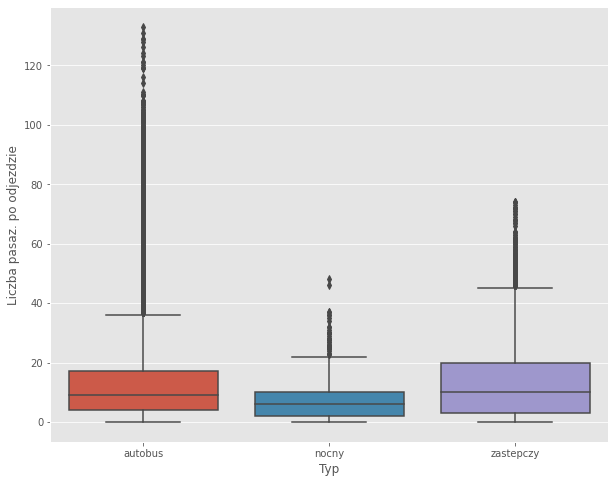

In [108]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    y='Liczba pasaz. po odjezdzie',
    x='Typ',
    data=df
)

<Figure size 432x288 with 0 Axes>

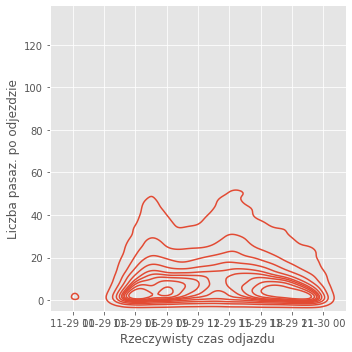

In [115]:
plt.figure()
ax = sns.displot(
    df,
    x='Rzeczywisty czas odjazdu',
    y='Liczba pasaz. po odjezdzie',
    kind='kde'
)

<Figure size 432x288 with 0 Axes>

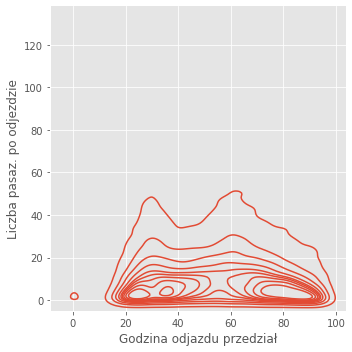

In [118]:
plt.figure()
ax = sns.displot(
    df,
    x='Godzina odjazdu przedział',
    y='Liczba pasaz. po odjezdzie',
    kind='kde'
)

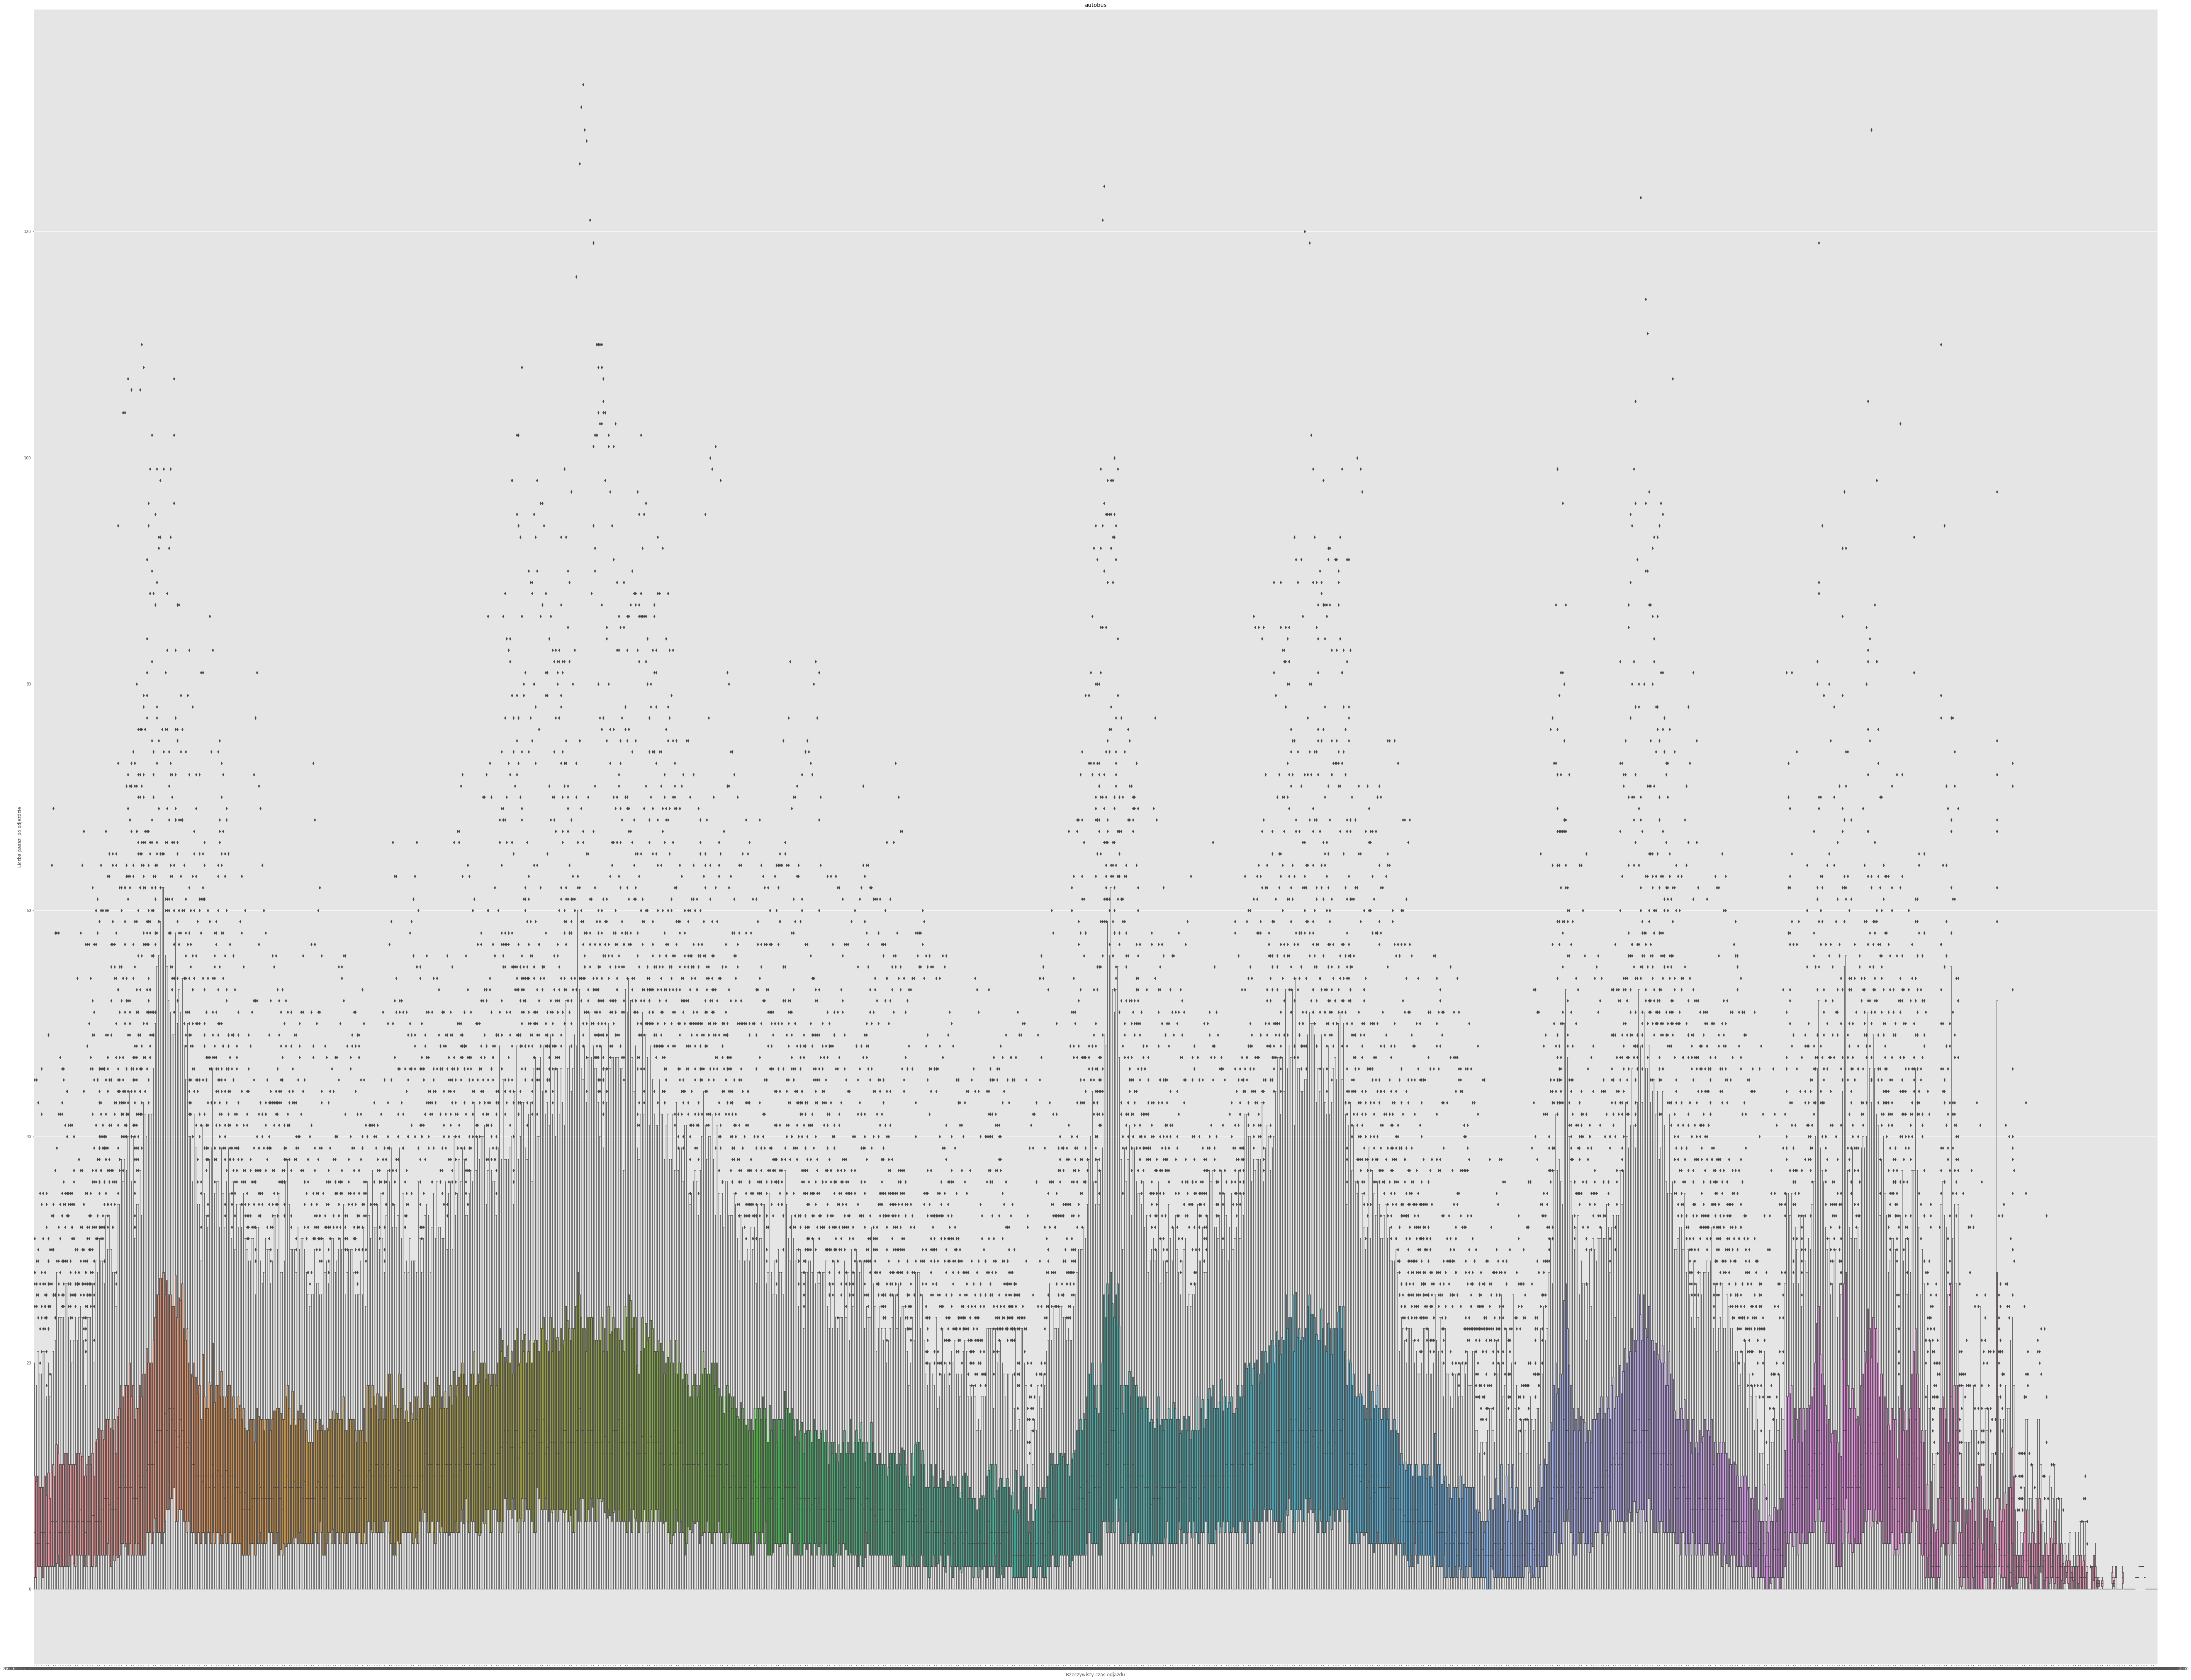

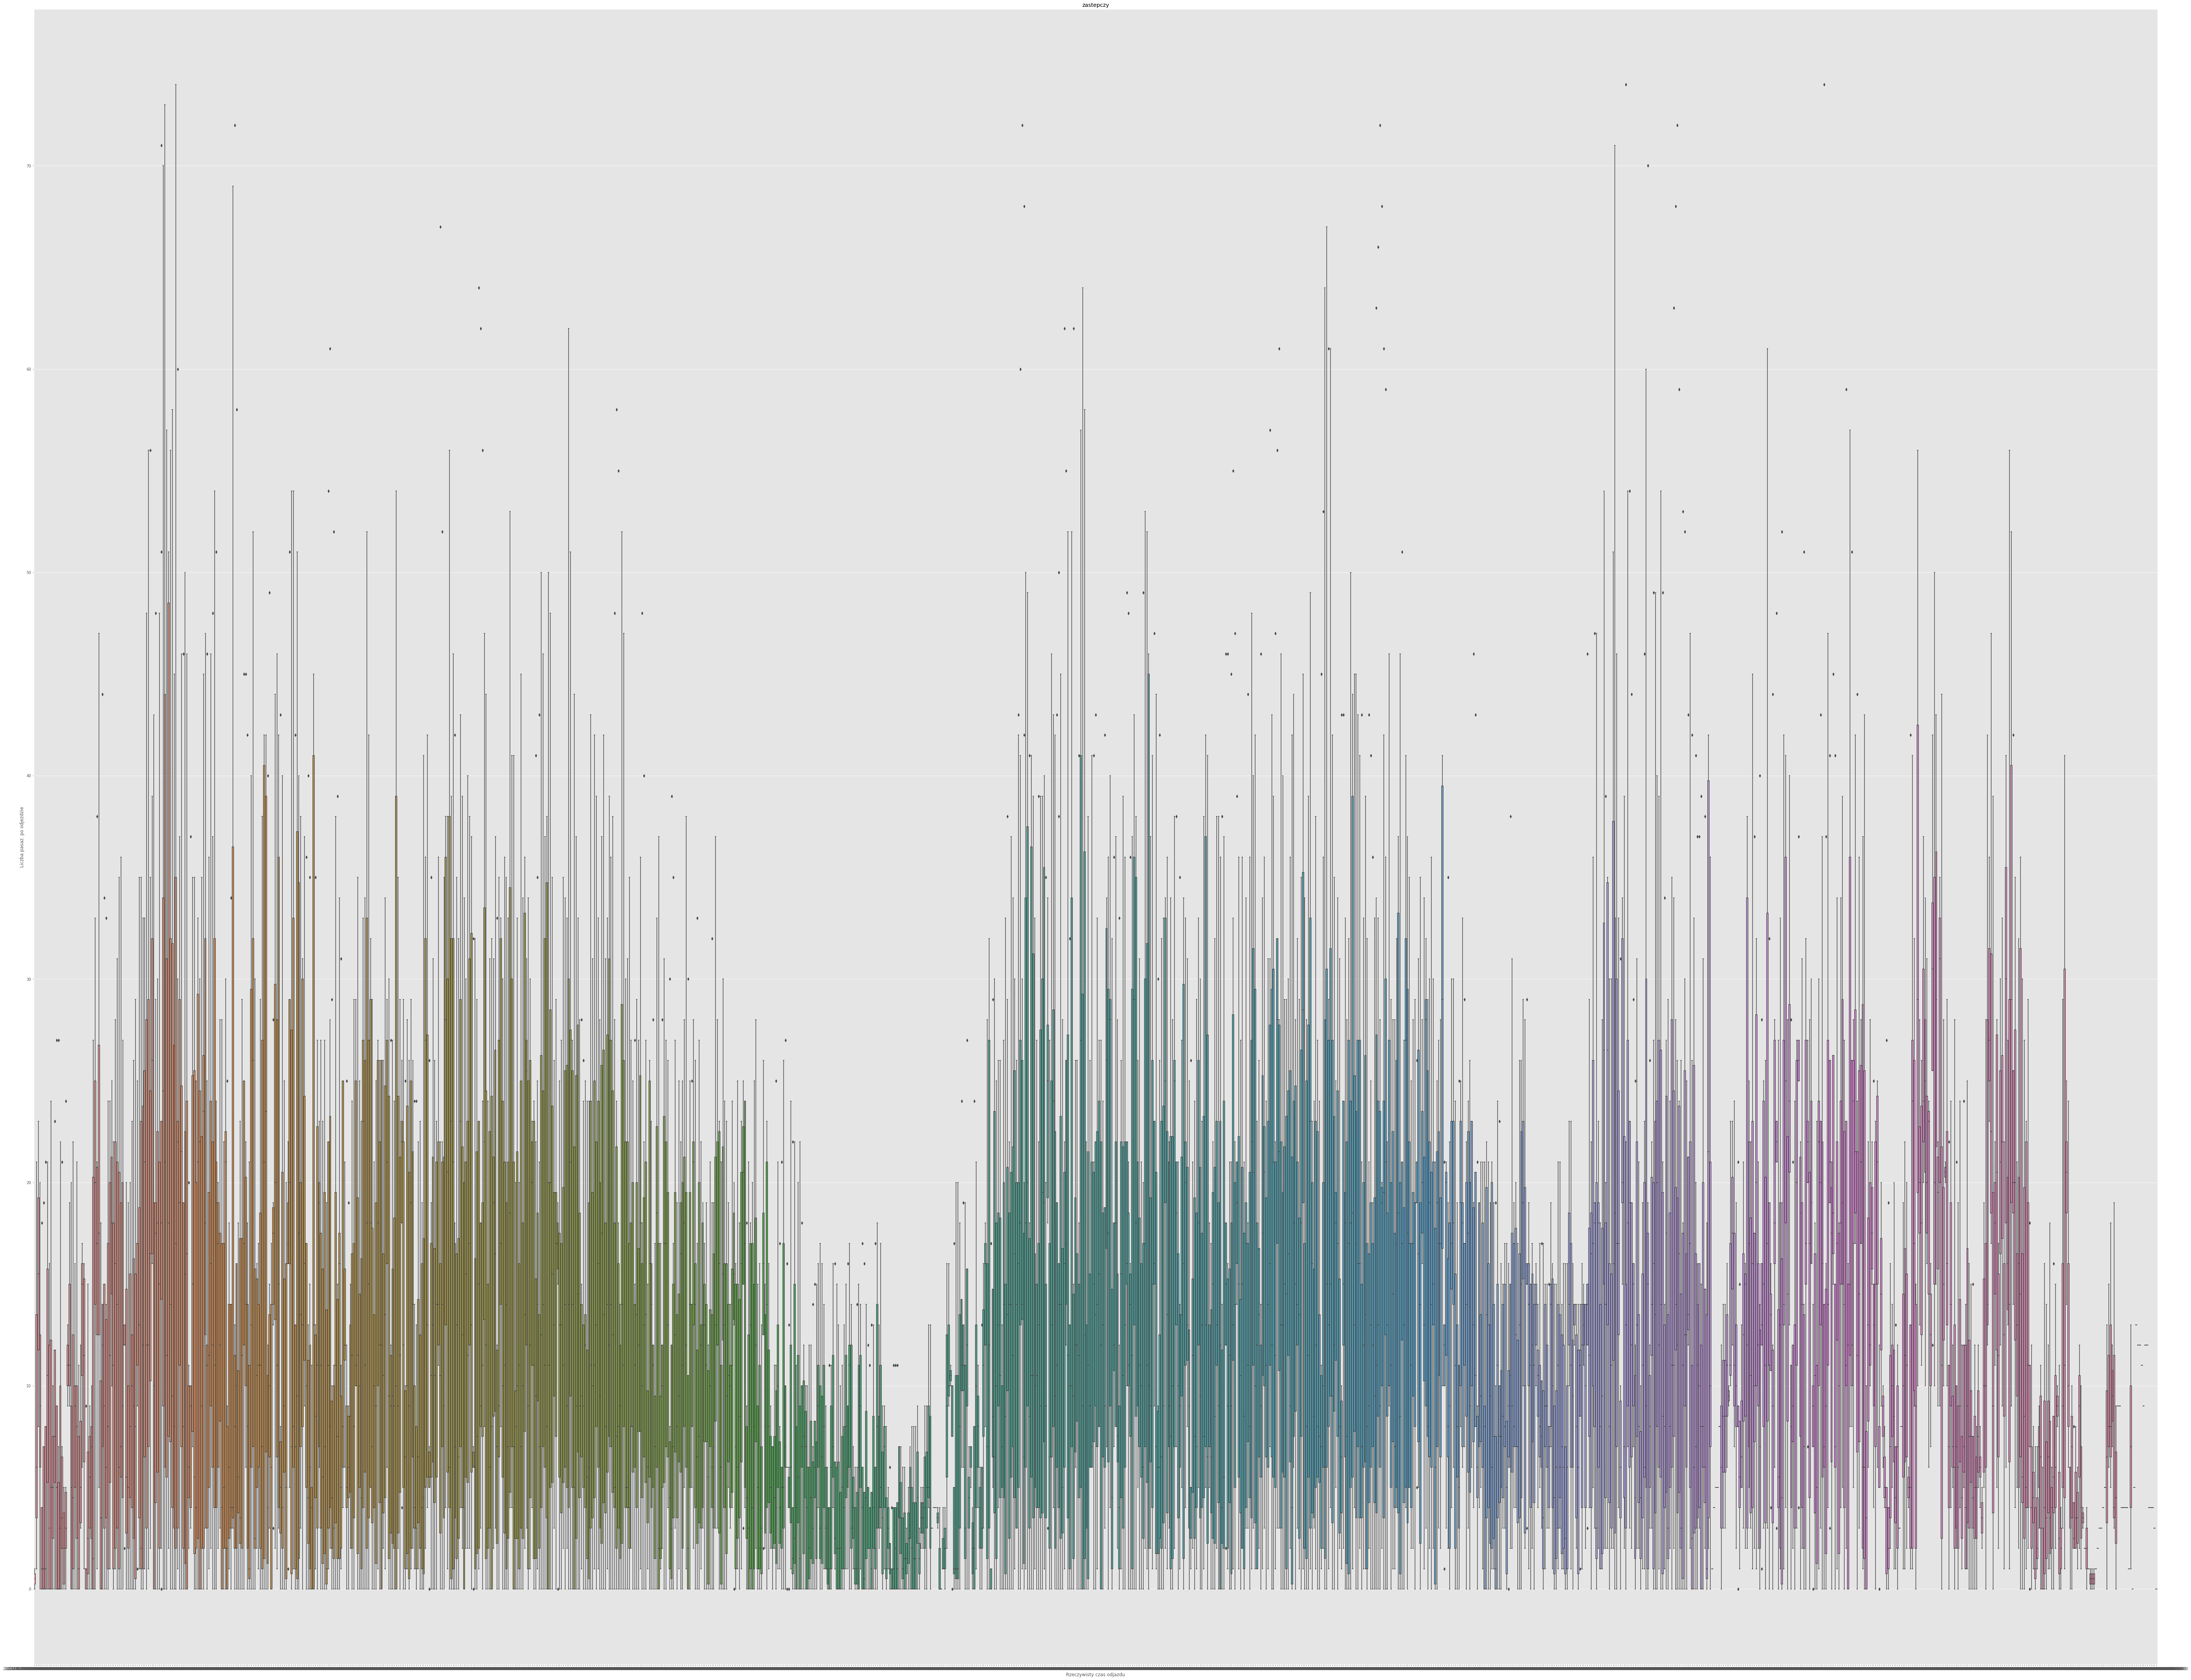

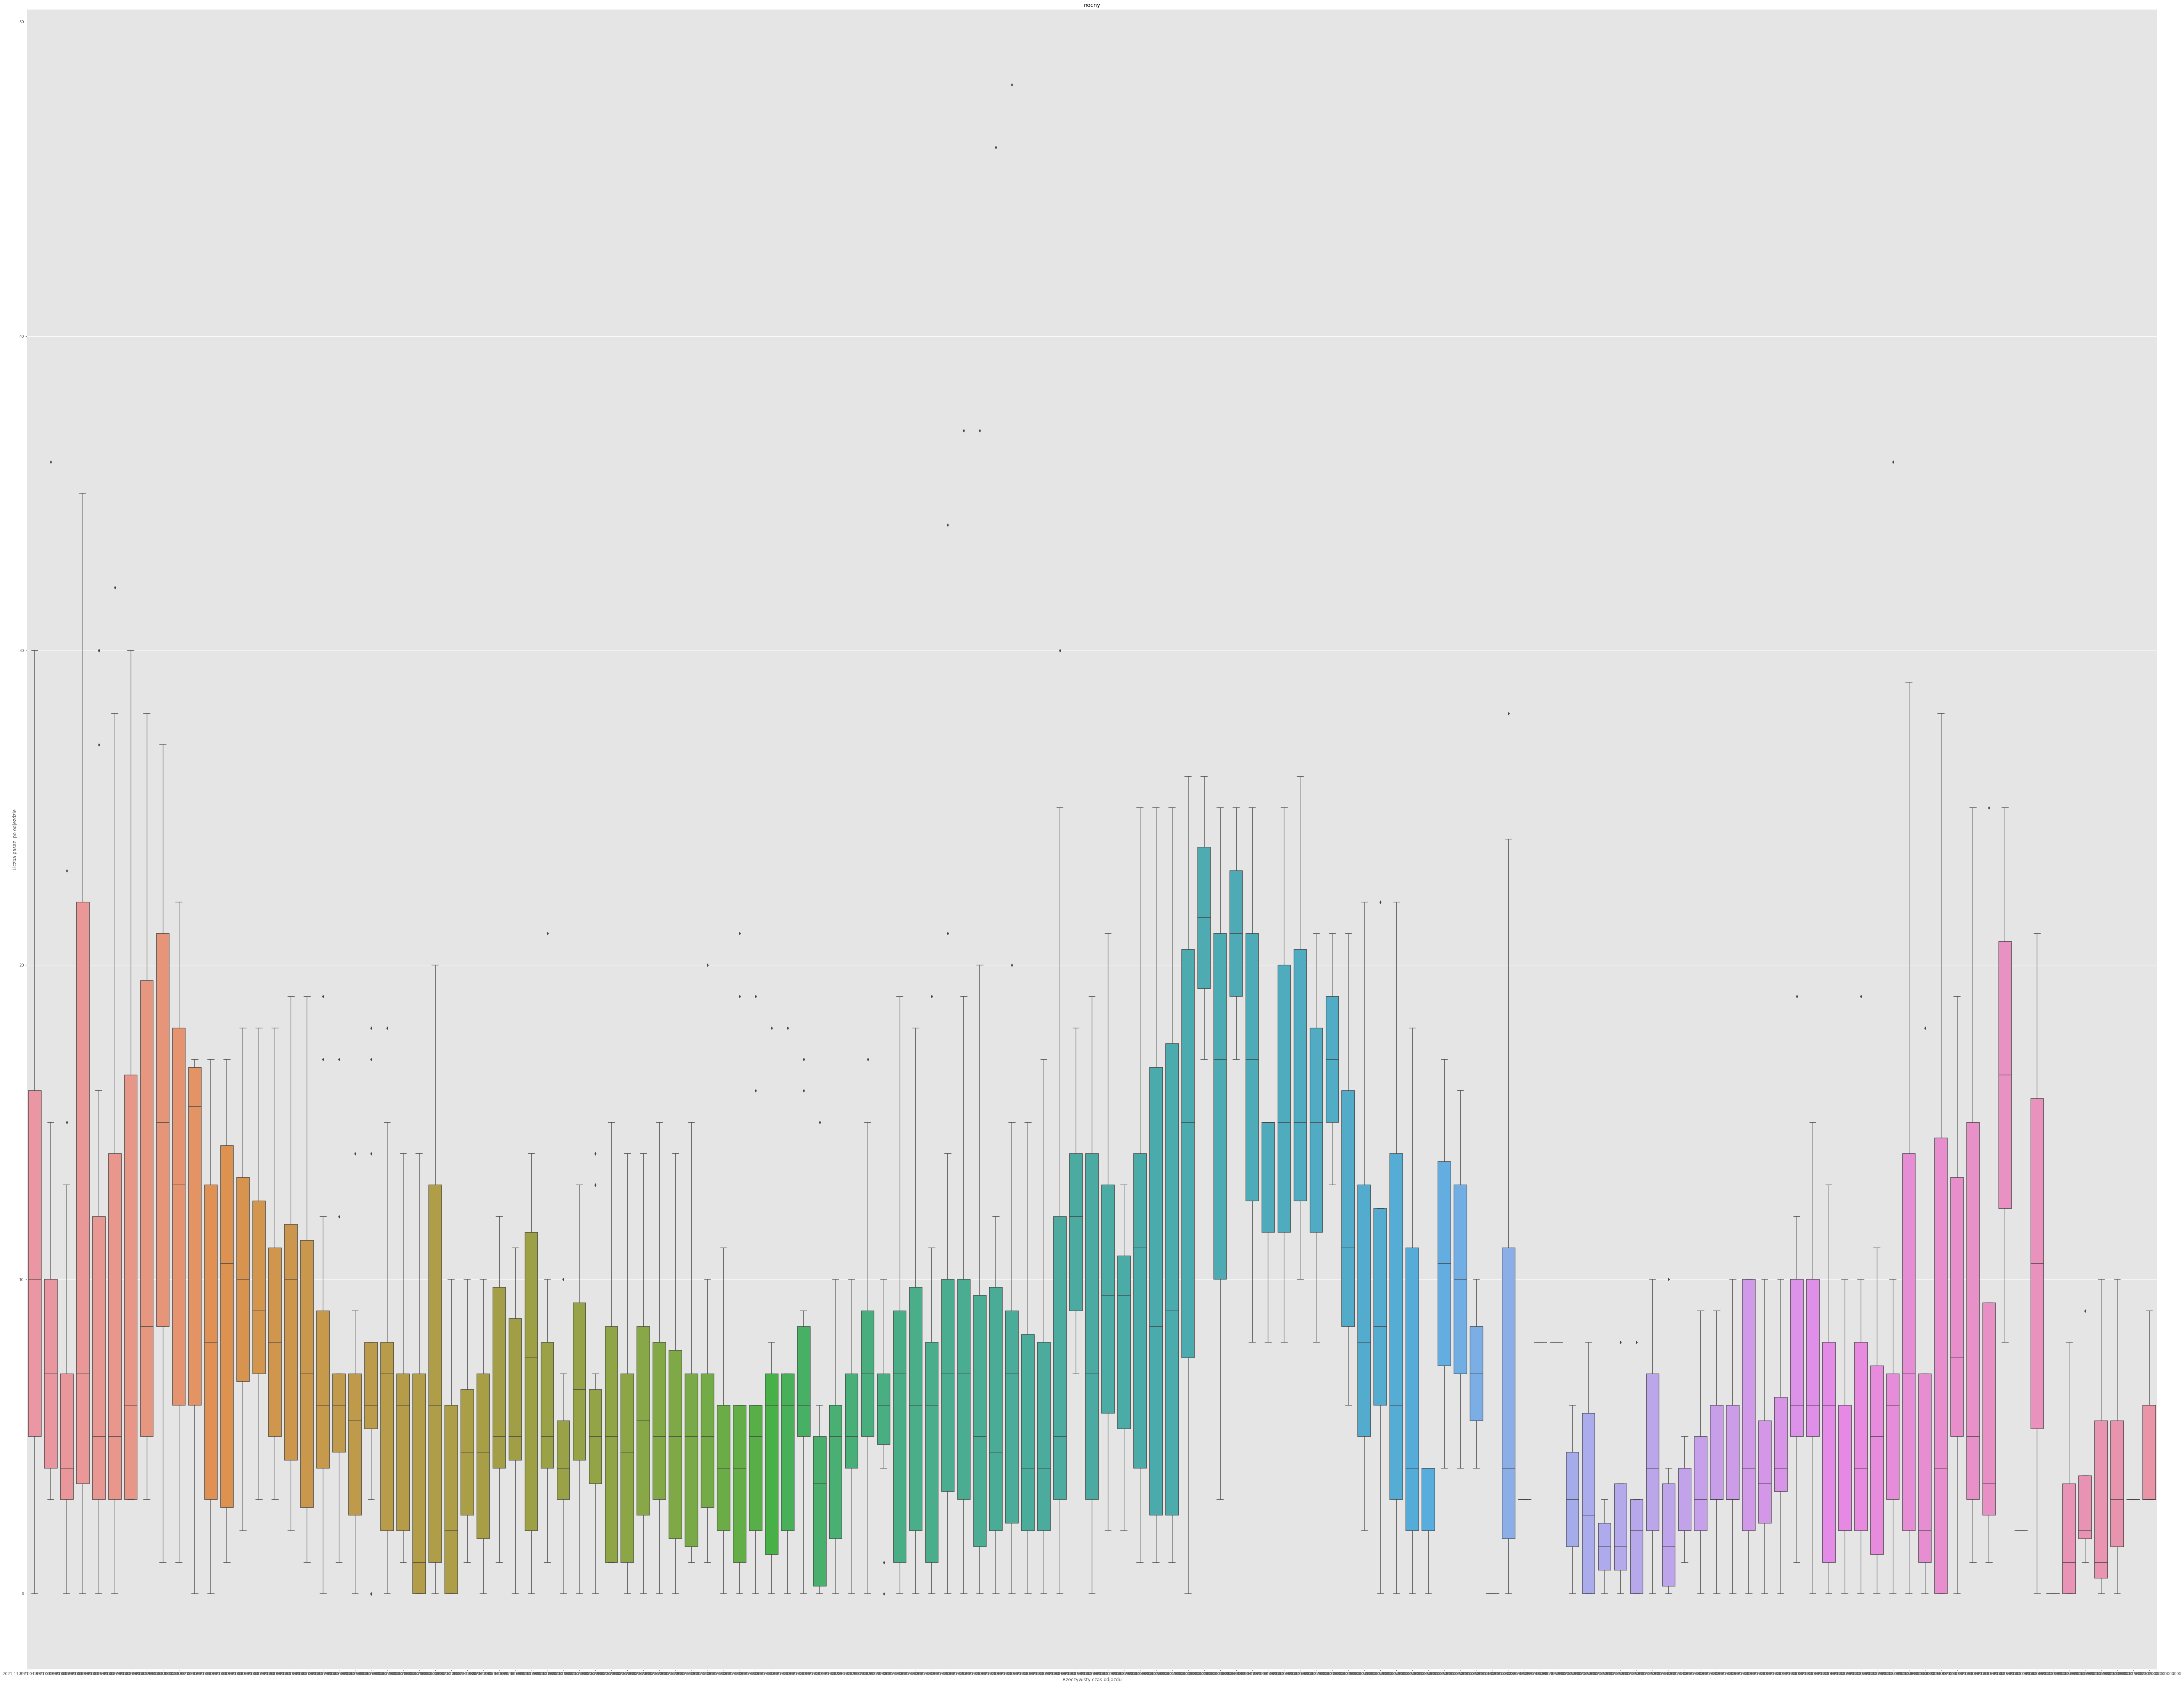

In [19]:
for trans_type in ['autobus', 'zastepczy', 'nocny']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Rzeczywisty czas odjazdu',
        y='Liczba pasaz. po odjezdzie',
        data=df.loc[df['Typ']==trans_type]
    )
    ax.set_title(trans_type)

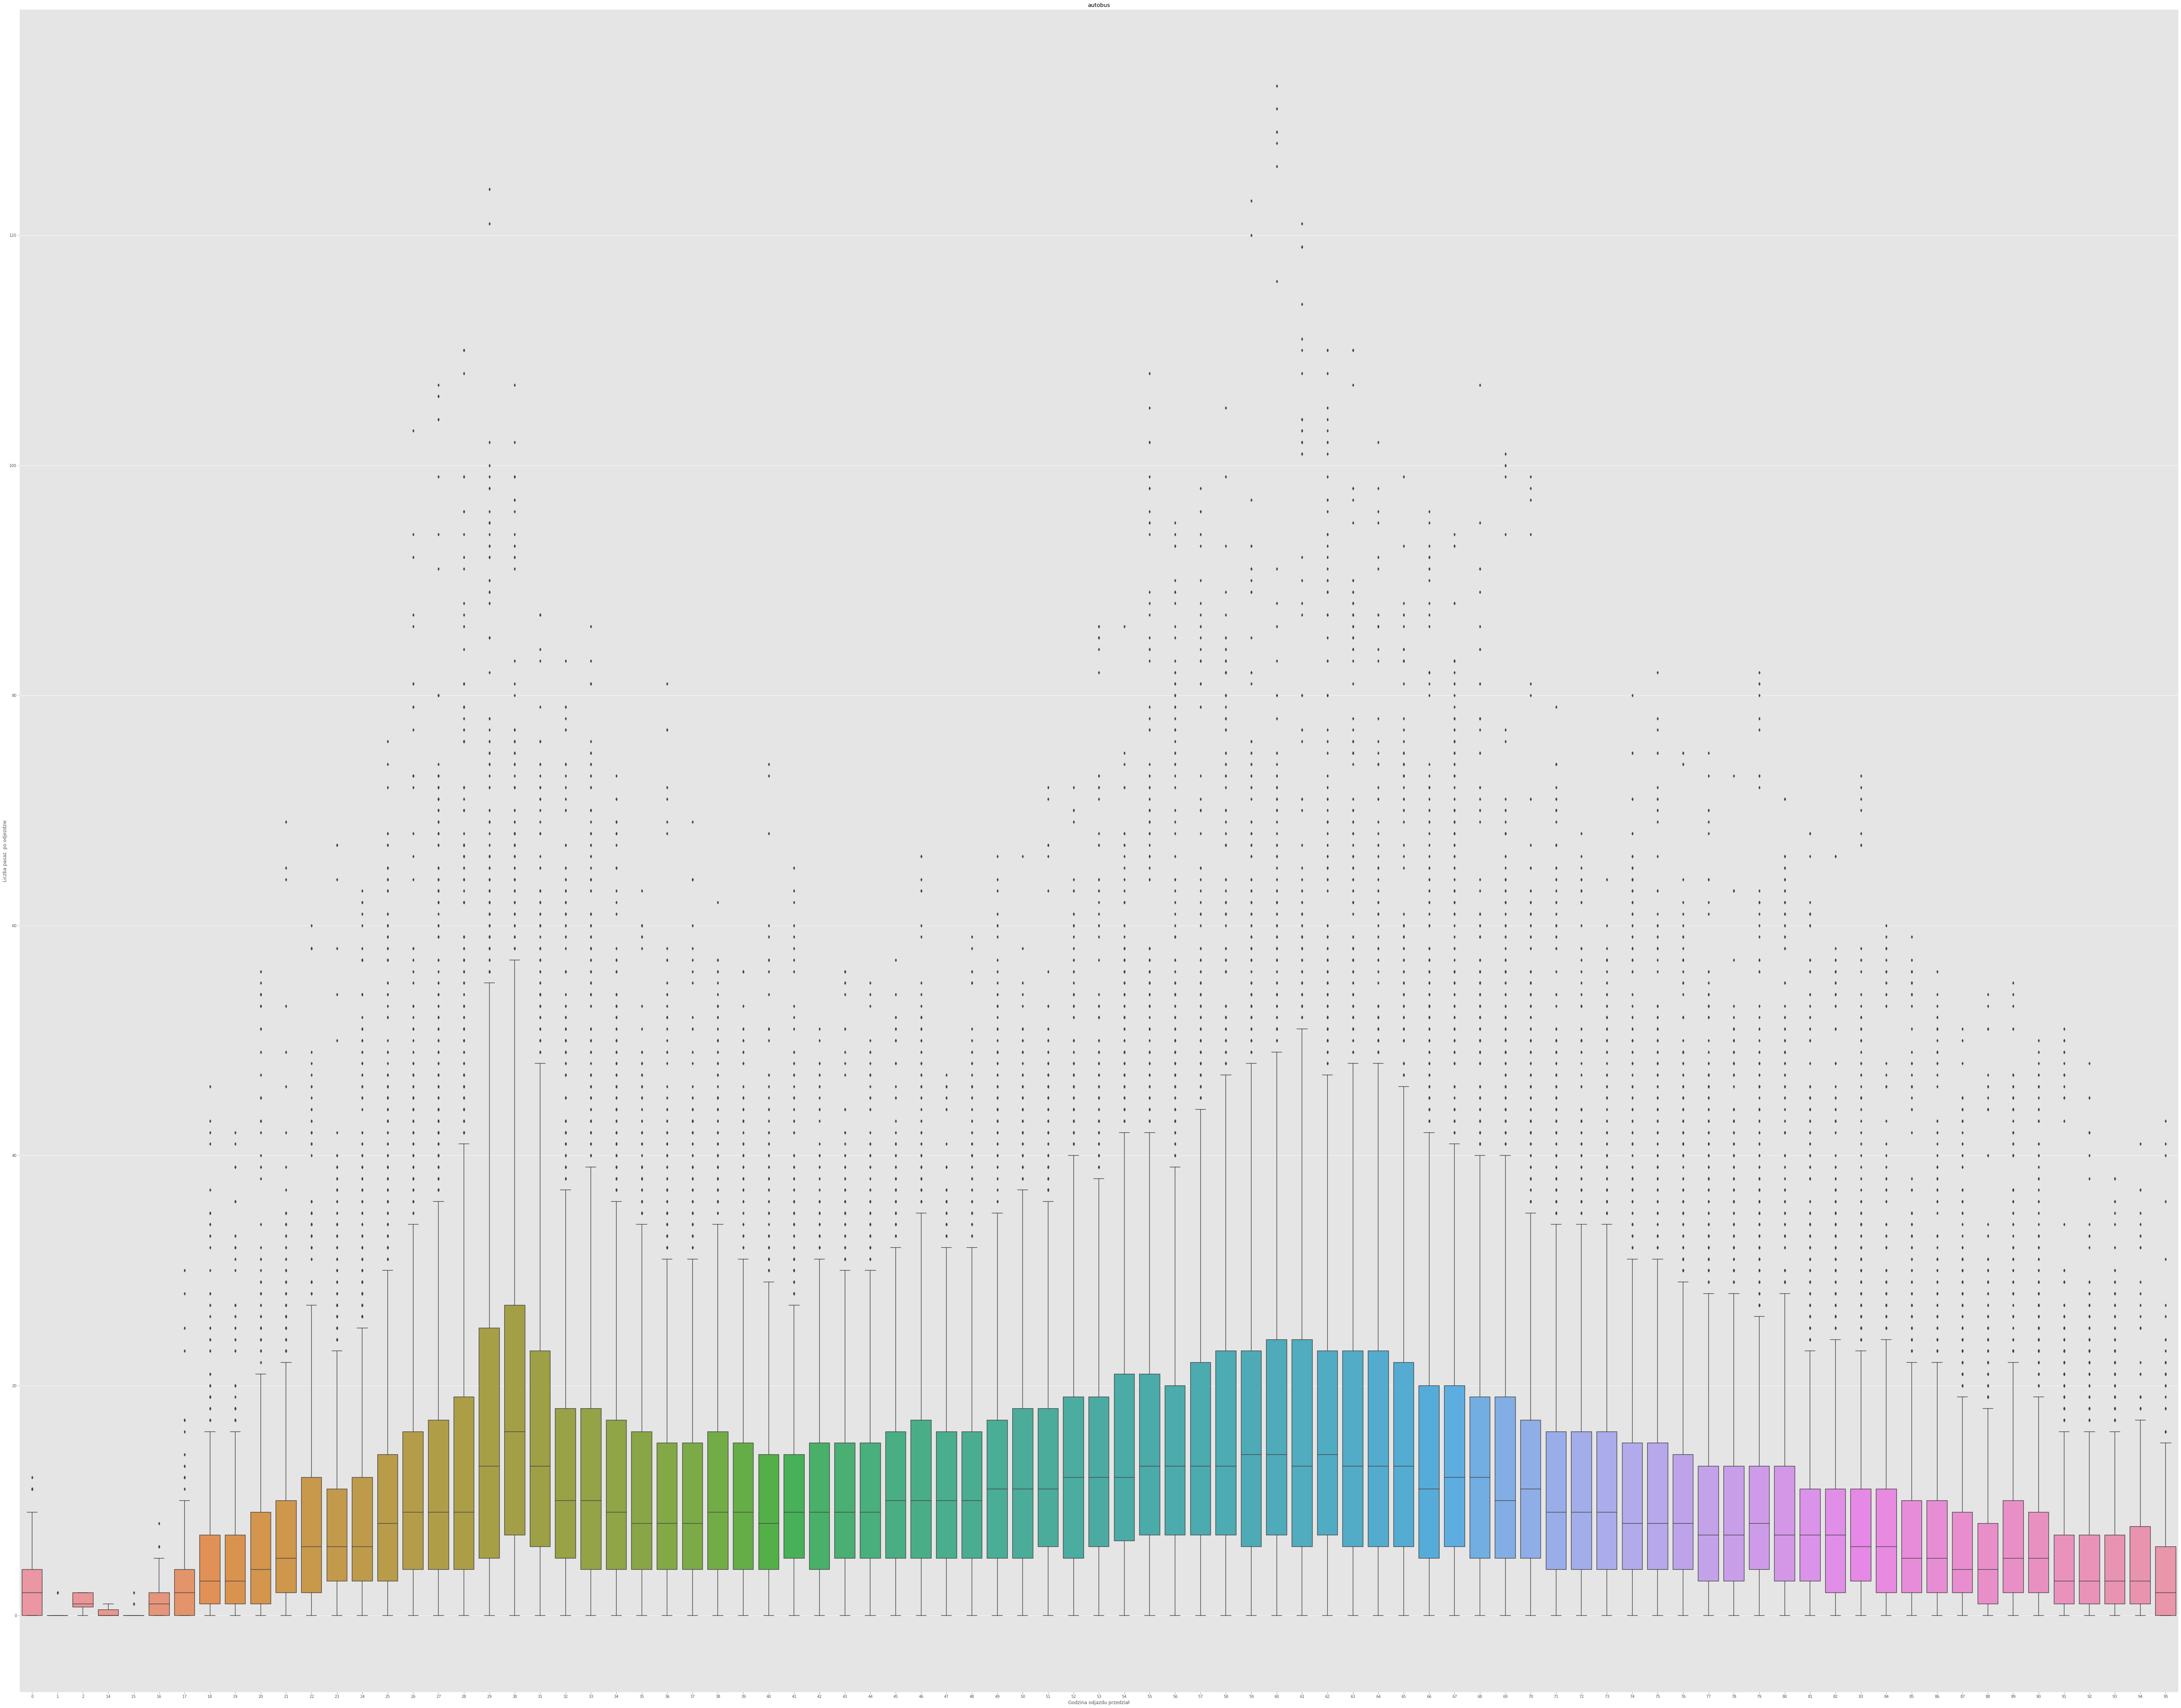

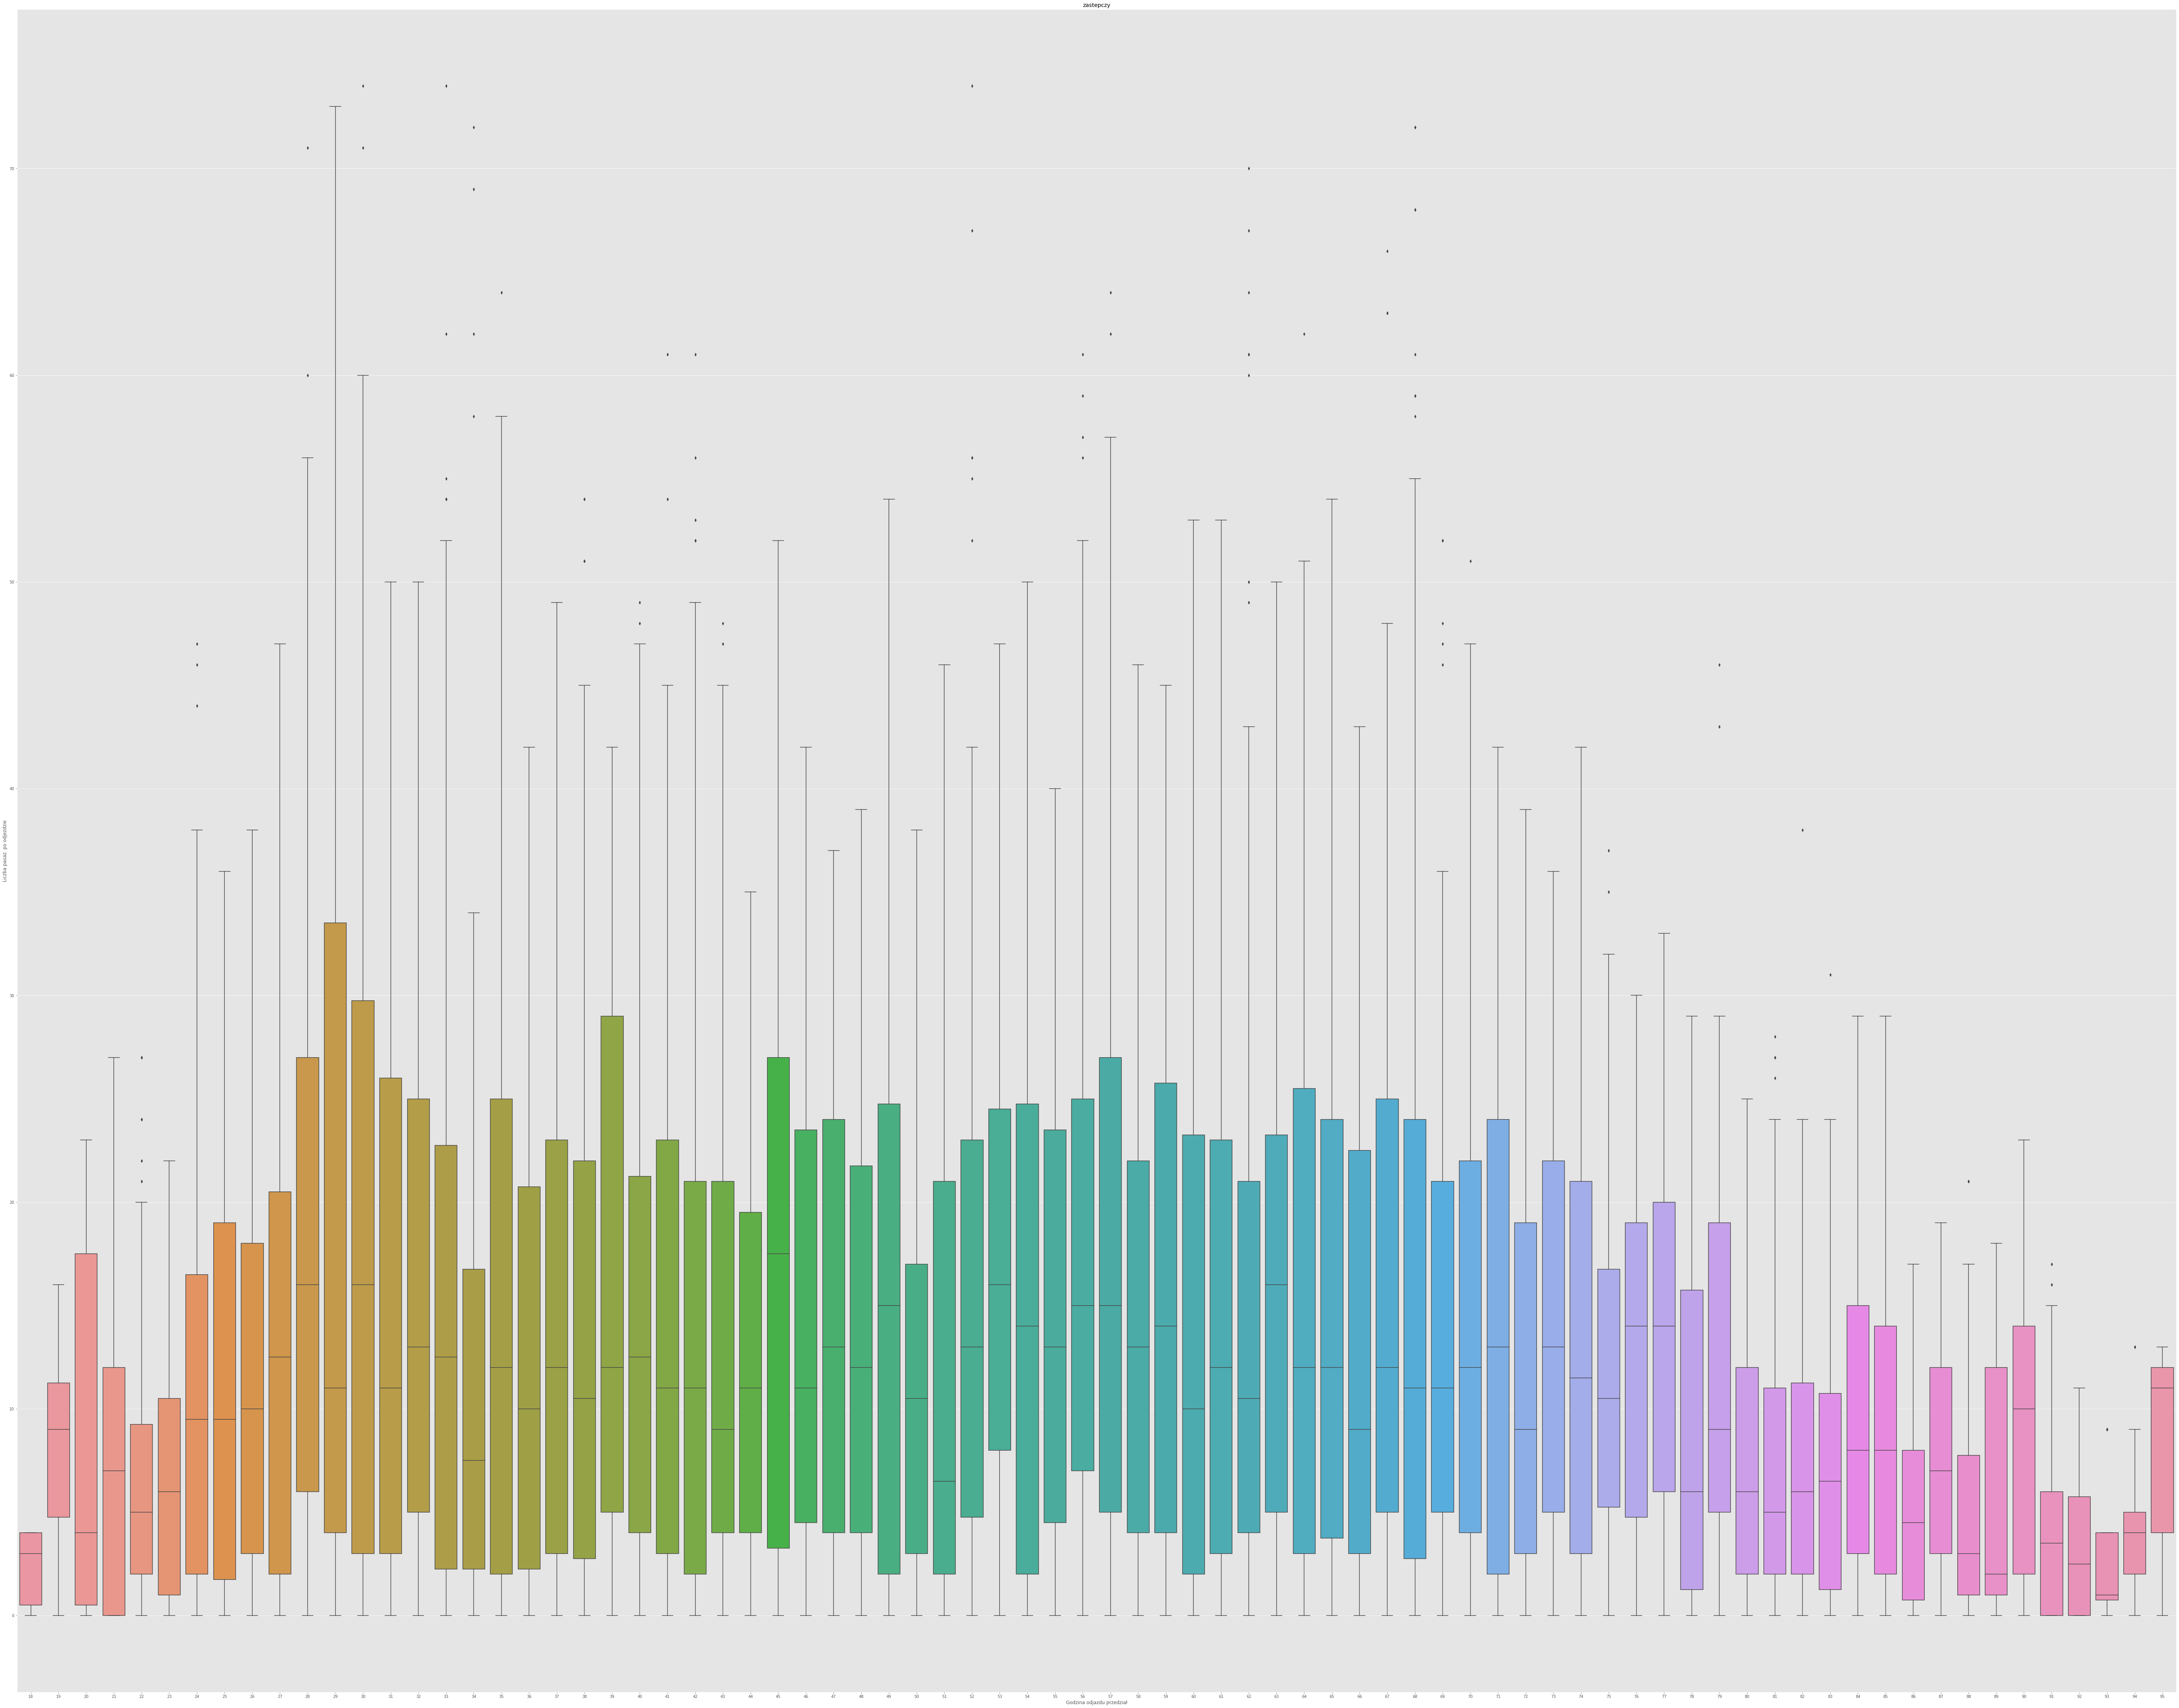

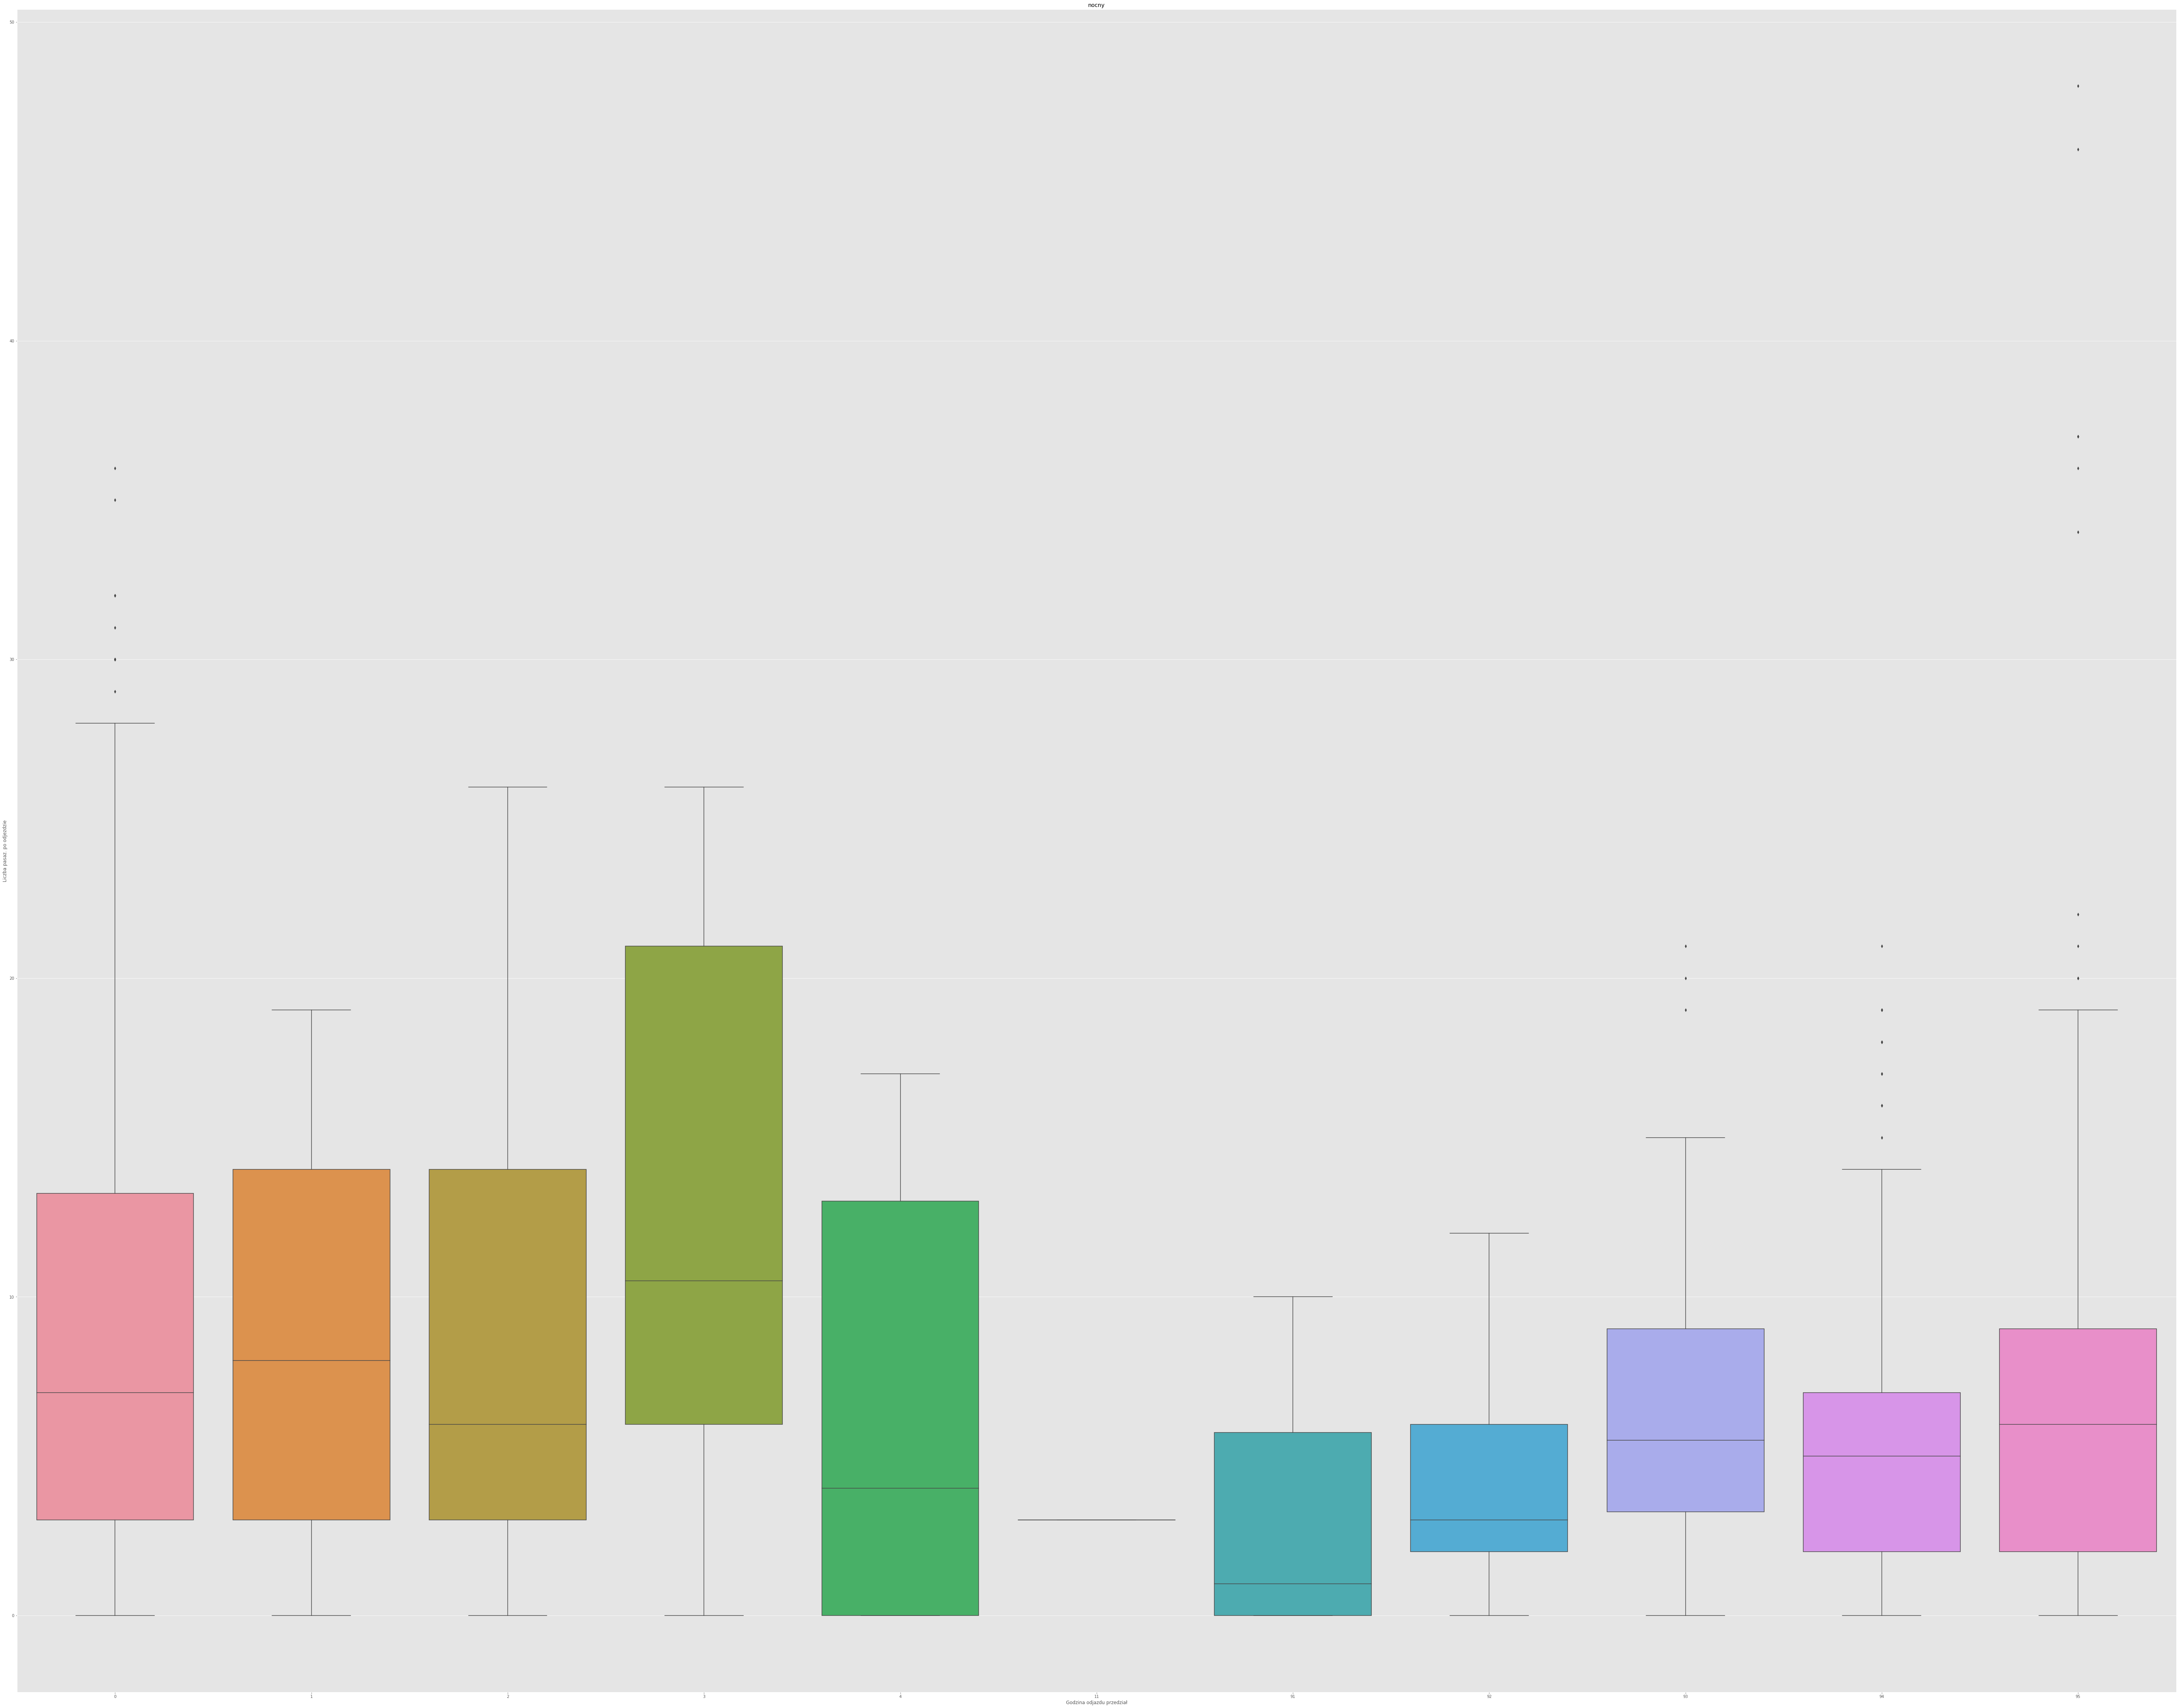

In [119]:
for trans_type in ['autobus', 'zastepczy', 'nocny']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Godzina odjazdu przedział',
        y='Liczba pasaz. po odjezdzie',
        data=df.loc[df['Typ']==trans_type]
    )
    ax.set_title(trans_type)

# 5.1. Porównanie wybranych lini do globalnego podejscia

In [128]:
df_no_type = df.drop(df[df['Typ'] != 'autobus'].index, inplace= False)
df_no_type.sample(5)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Typ,class,Godzina odjazdu przedział
141116,525,TP-MIE,2021-11-29 16:45:00,4,9836,Centrum Zdrowia Dziecka,2,2021-11-29 17:32:00,2021-11-29 17:34:00,4,2,0,2,17.566667,autobus,pusto,70
57272,176,TP-BUD,2021-11-29 20:14:00,1,9401,Starego Dębu,1,2021-11-29 20:18:00,2021-11-29 20:17:00,5,0,0,5,20.283333,autobus,pusto,81
164663,809,TP-UPD,2021-11-29 19:42:00,55,9238,PKP Jeziorki,3,2021-11-29 19:42:00,2021-11-29 19:42:00,0,0,1,1,19.700000,autobus,pusto,78
162823,743,TP-WOL,2021-11-29 22:42:00,1,9423,Szeligowska-Wiadukt,2,2021-11-29 22:52:00,2021-11-29 22:53:00,8,0,0,8,22.883333,autobus,pusto,91
67707,179,TP-UPN,2021-11-29 07:48:00,13,9312,Mandarynki,2,2021-11-29 08:00:00,2021-11-29 08:05:00,18,1,2,19,8.083333,autobus,średnie zatłoczenie,32


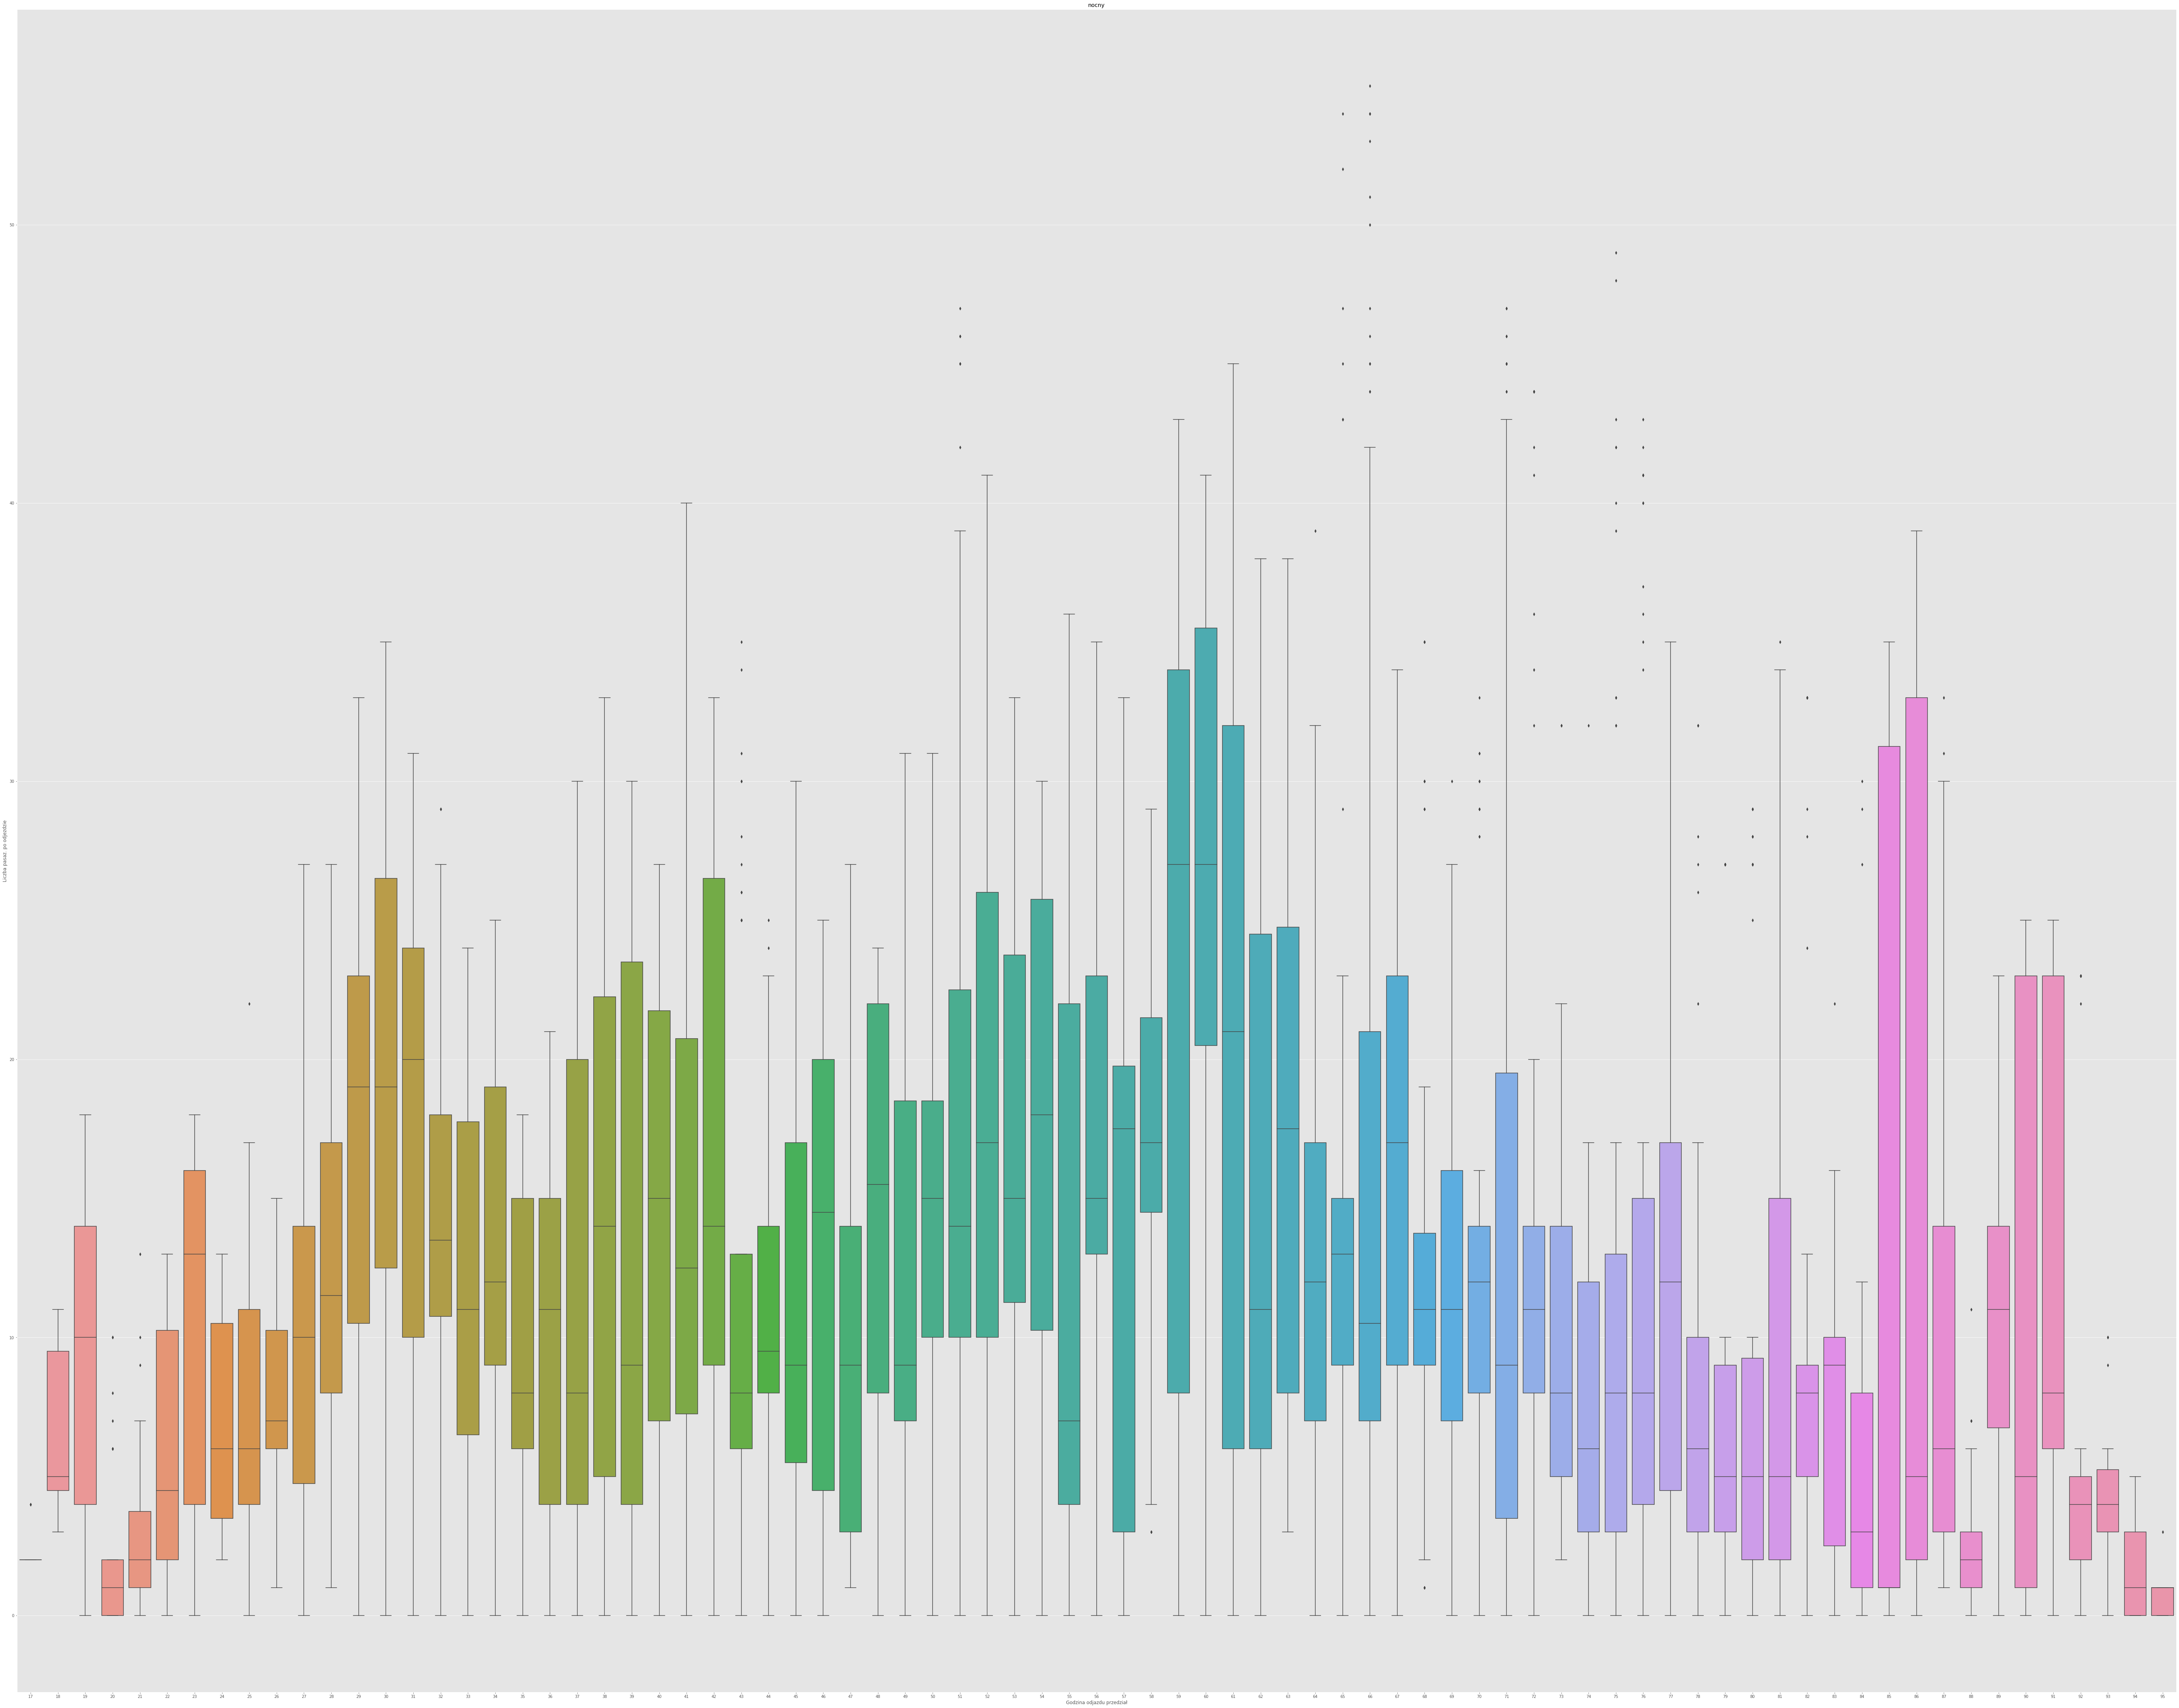

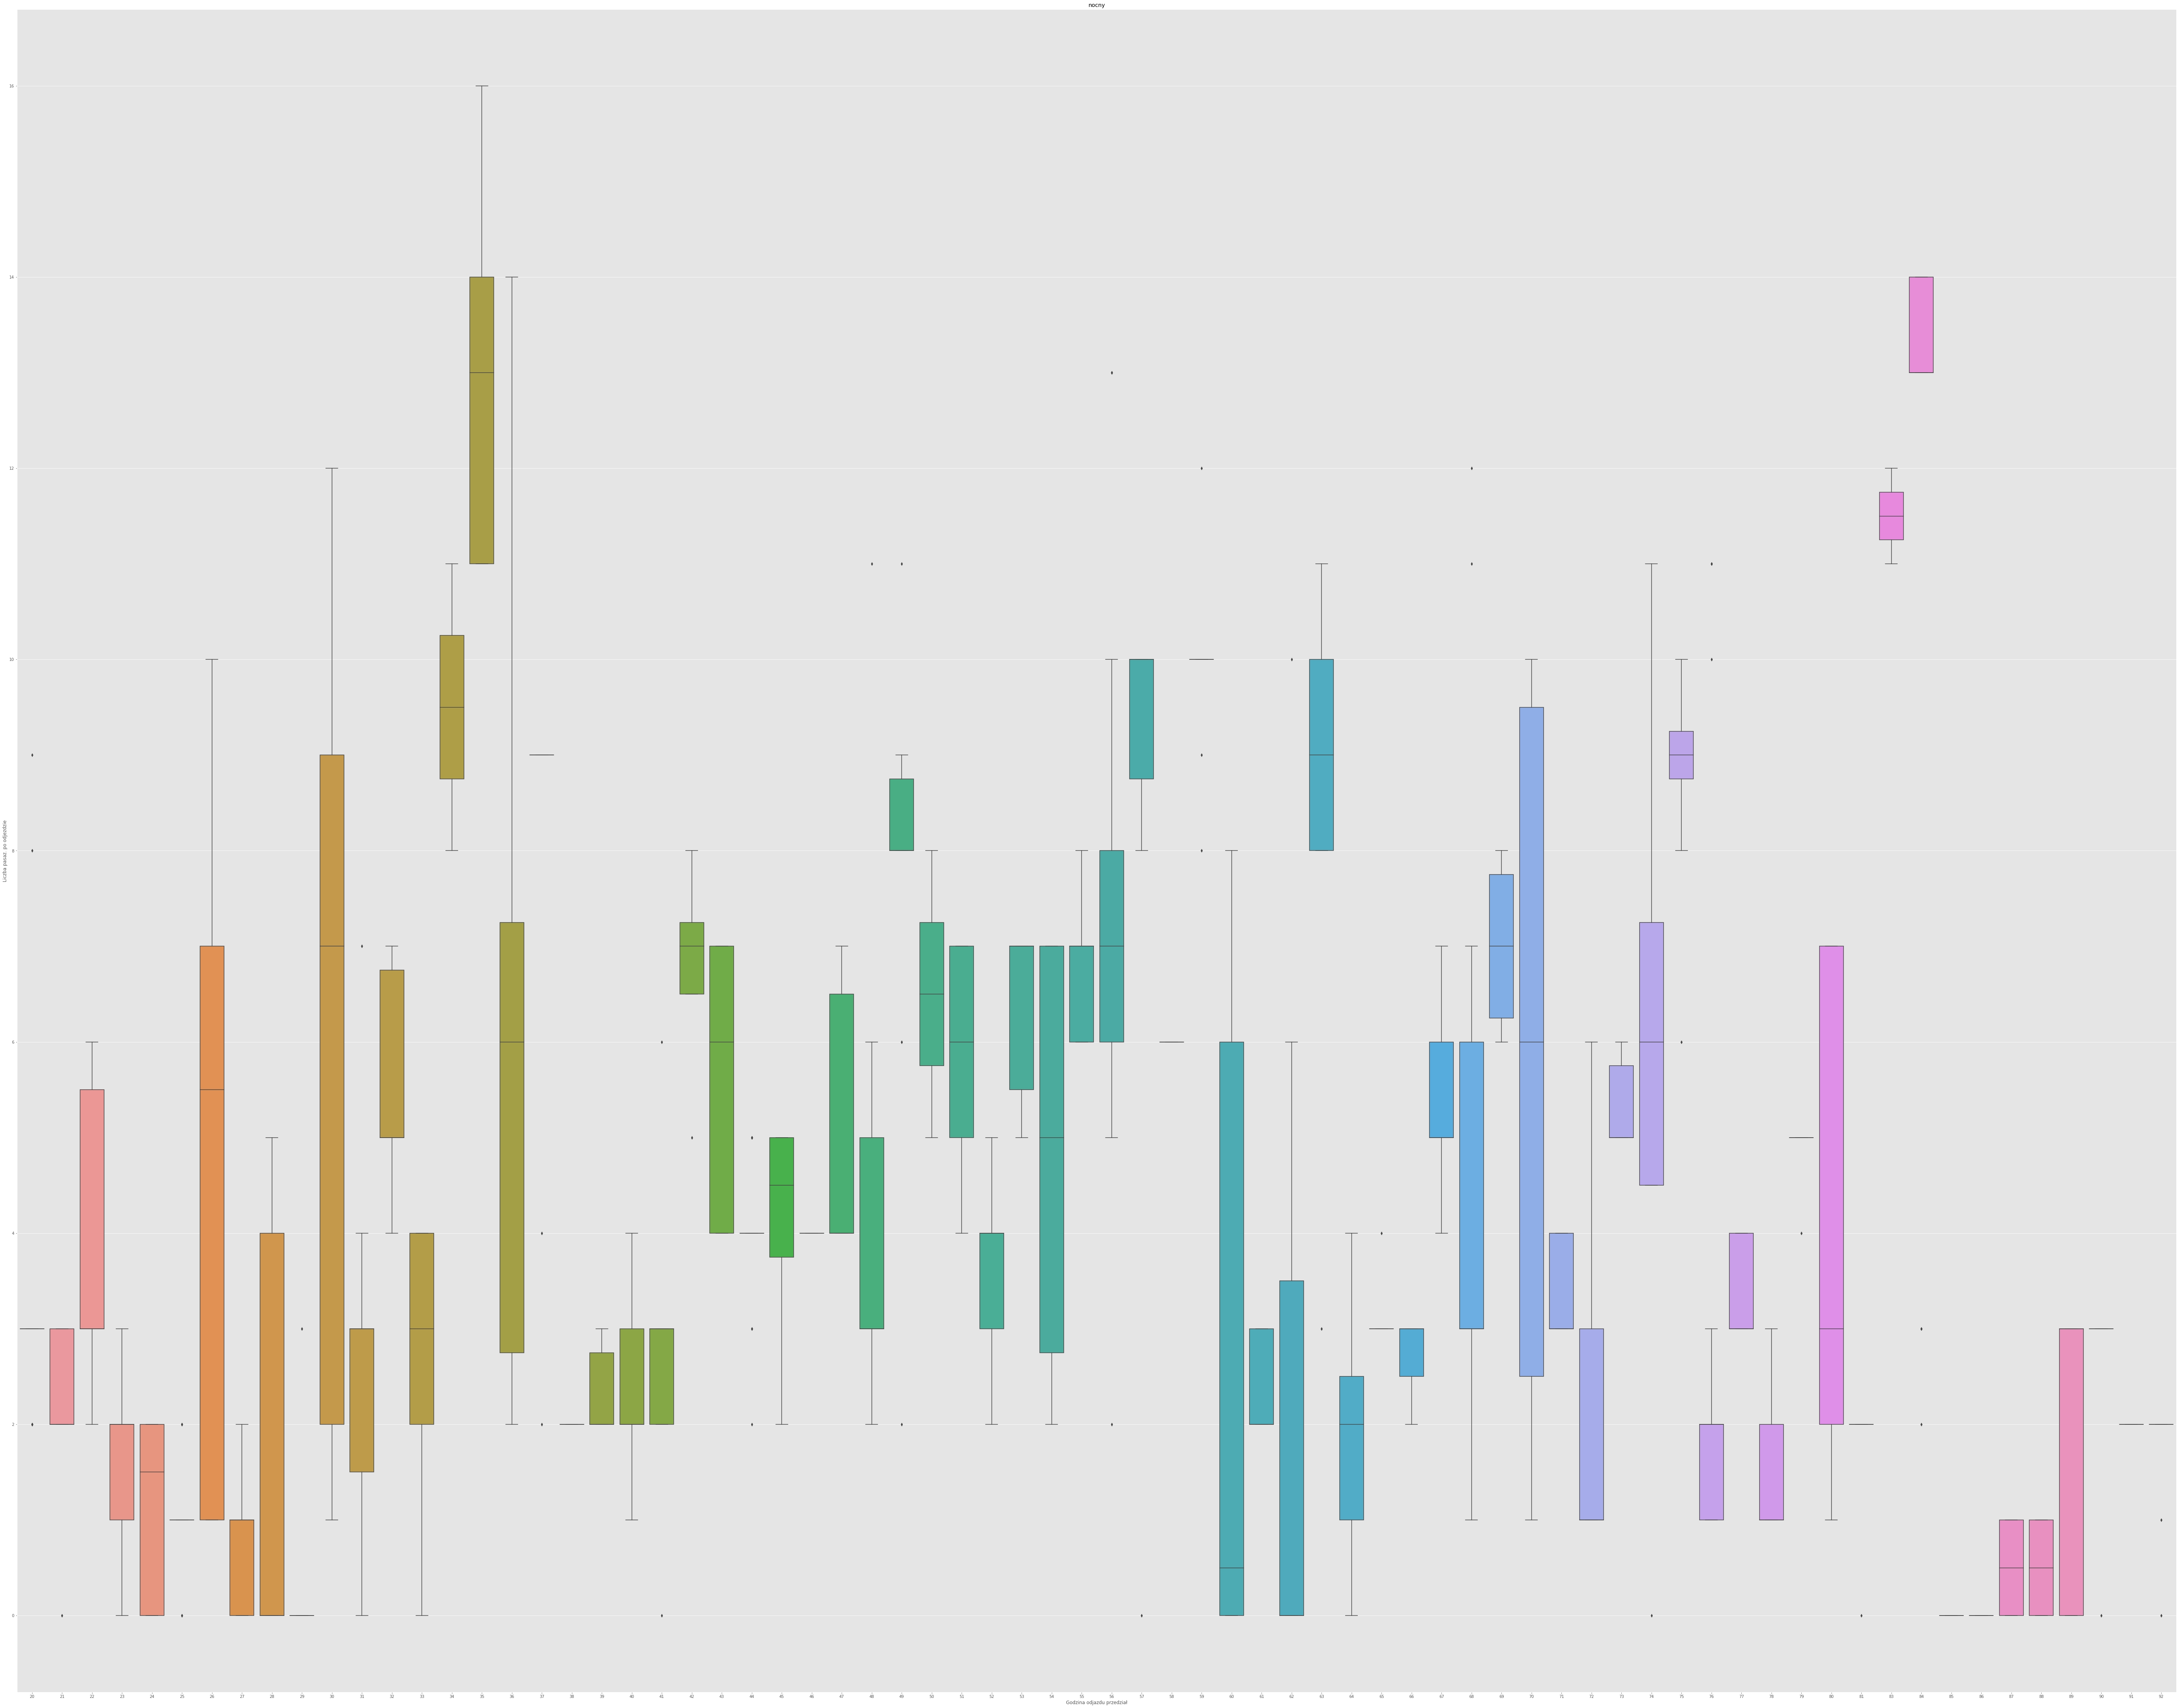

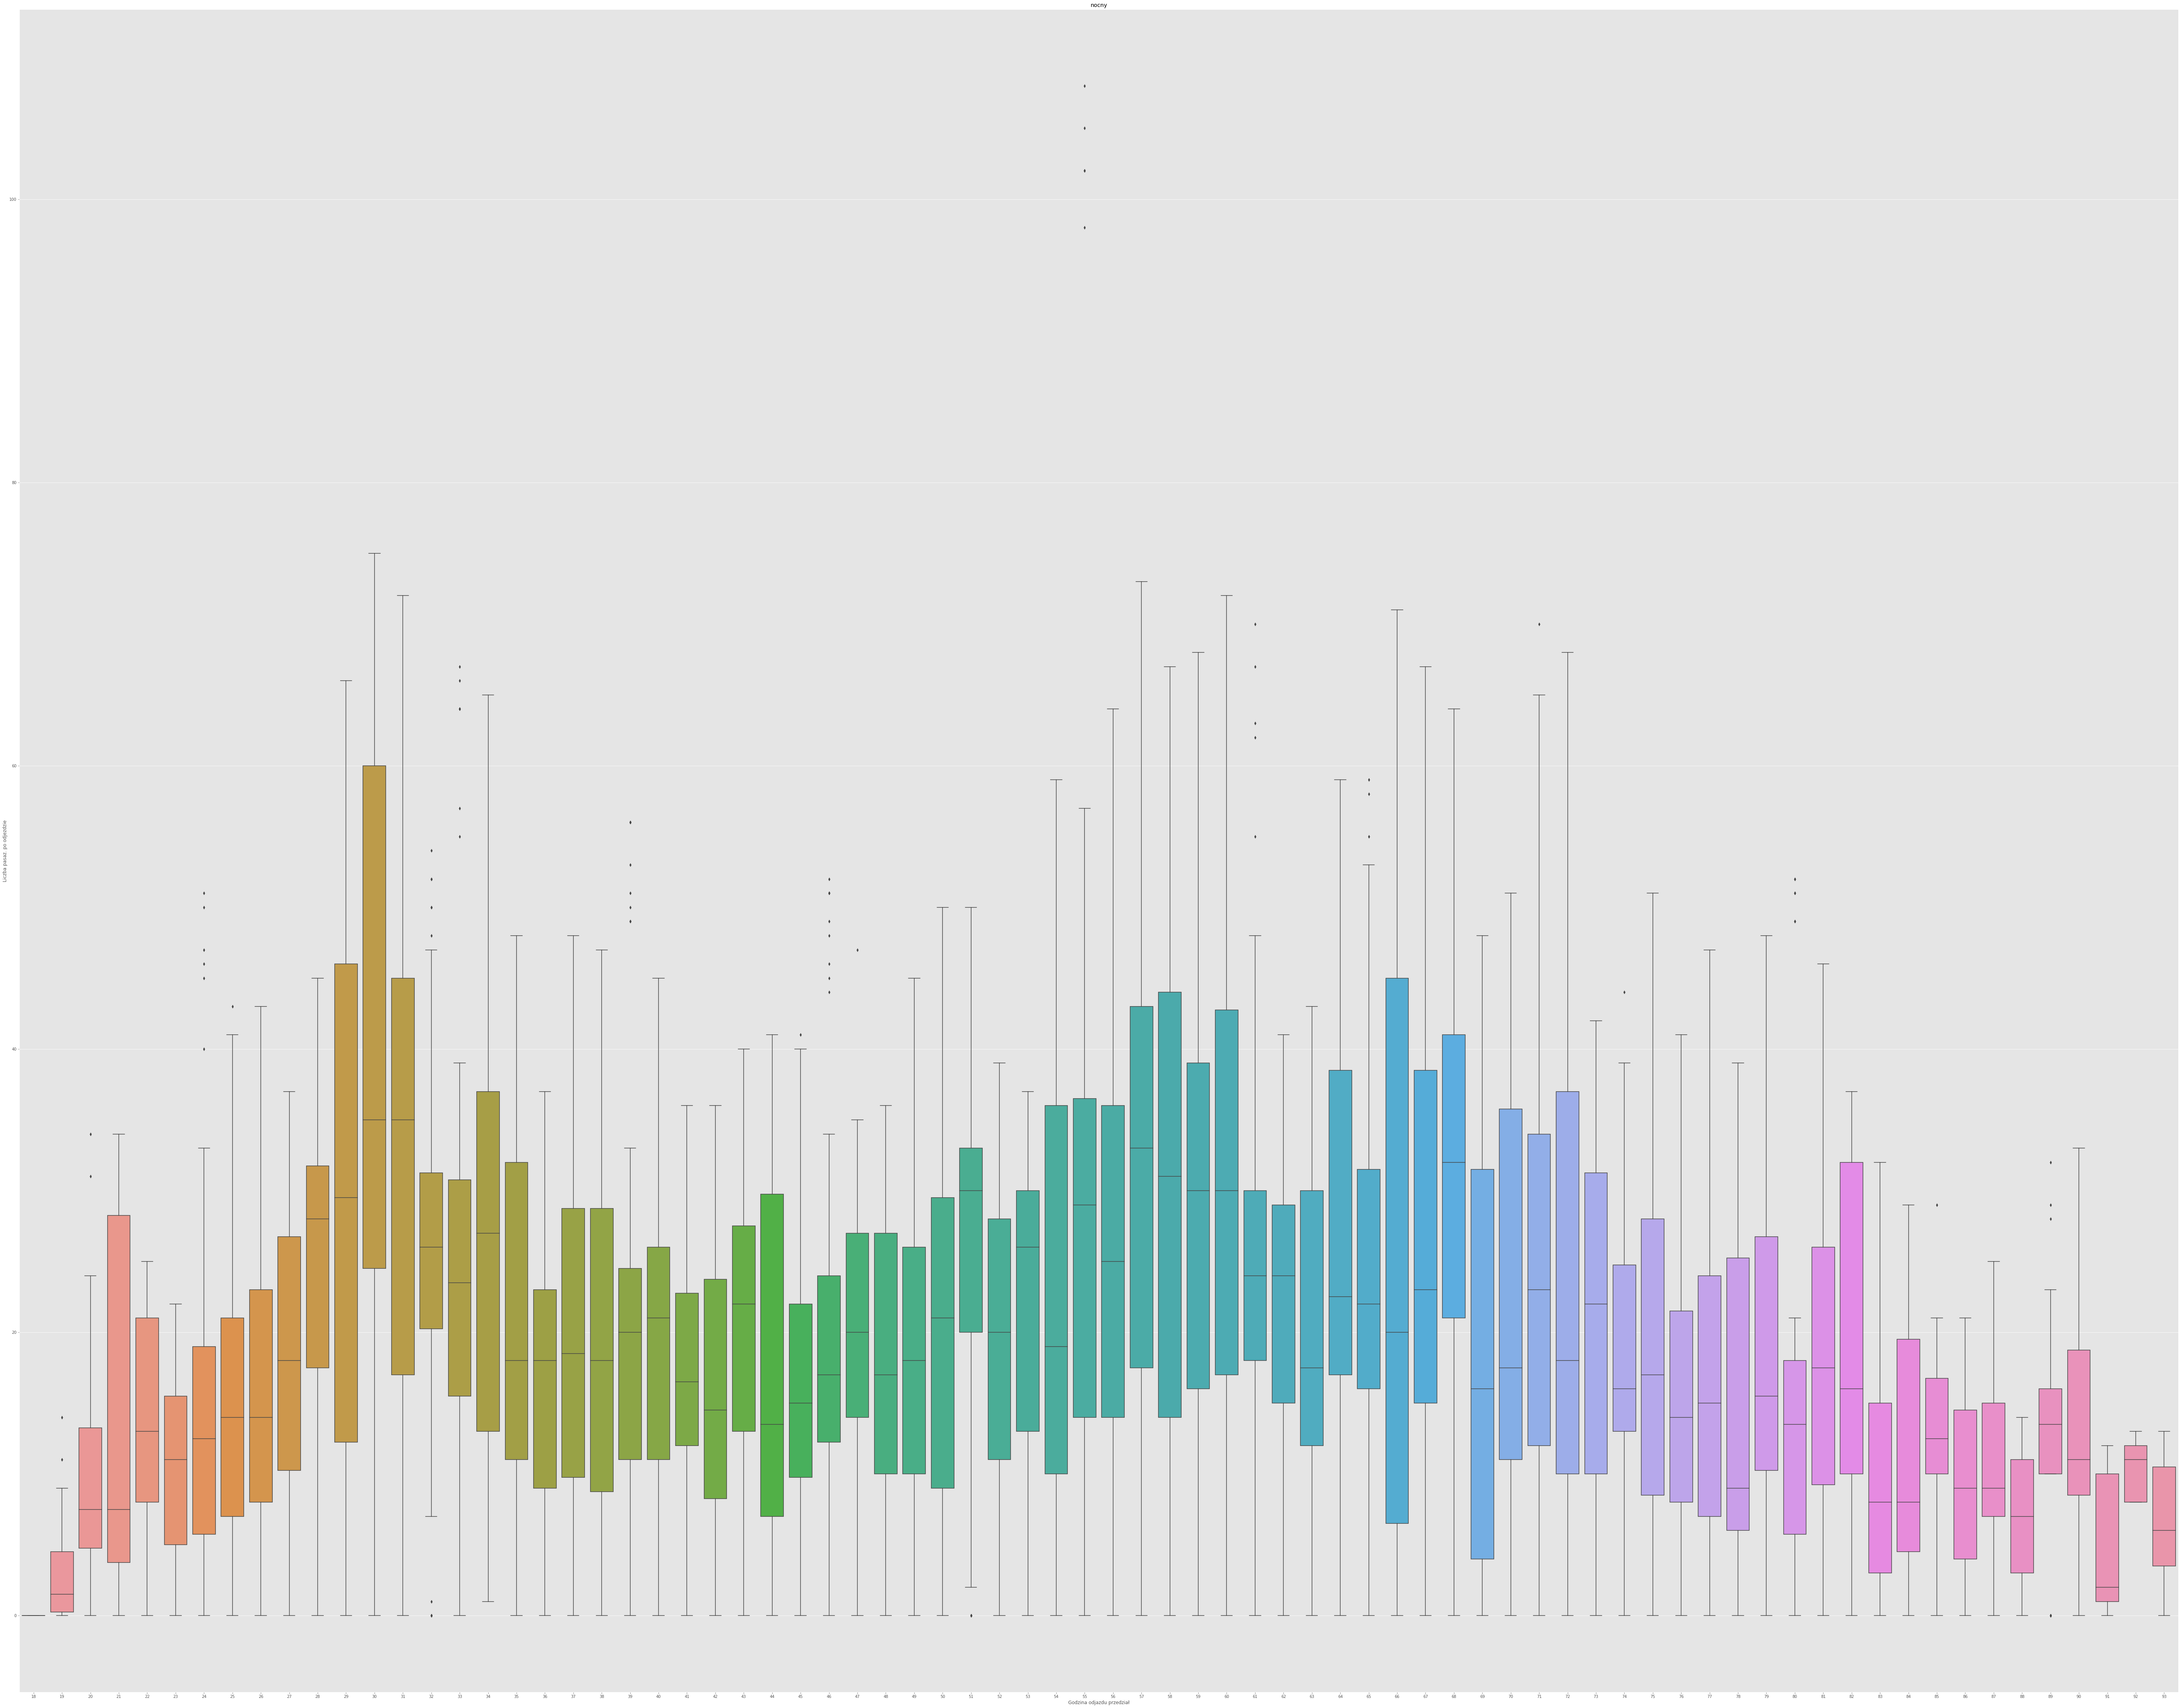

In [129]:
for line_number in ['142', '264', '525']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Godzina odjazdu przedział',
        y='Liczba pasaz. po odjezdzie',
        data=df_no_type.loc[df['Nr linii']==line_number]
    )
    ax.set_title(trans_type)

# 6. Clustering

In [104]:
def find_clusters(speeds, iterations, df, column):
    k = len(speeds)
    data = np.array(df[column]).reshape(1,-1).T
    clusters = KMeans(
        n_clusters = k,
        max_iter = iterations,
        random_state = RANDOM_SEED
    ).fit(data)
    
    cc, *_ = clusters.cluster_centers_.reshape(1,k)
    cc_ord = np.argsort(cc)
    class_mapping = dict(zip(cc_ord, speeds))
    
    df['class'] = clusters.labels_
    df['class'] = df['class'].map(class_mapping)
    
    return df

In [105]:
crowding = ['pusto','małe zatłoczenie', 'średnie zatłoczenie', 'duze zatłoczenie', 'olbrzymie zatłoczenie']
iterations = 10

df = find_clusters(crowding, iterations, df, 'Liczba pasaz. po odjezdzie')

<Figure size 720x576 with 0 Axes>

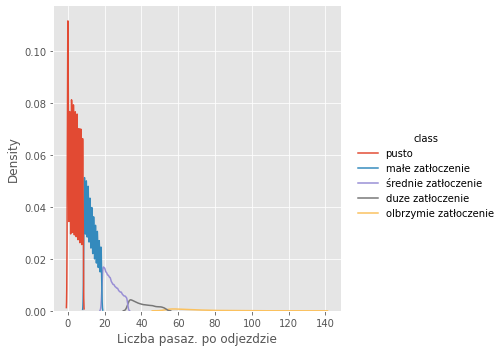

In [106]:
plt.figure(figsize=(10, 8))
ax = sns.displot(
    df,
    x='Liczba pasaz. po odjezdzie',
    hue='class',
    kind='kde'
)

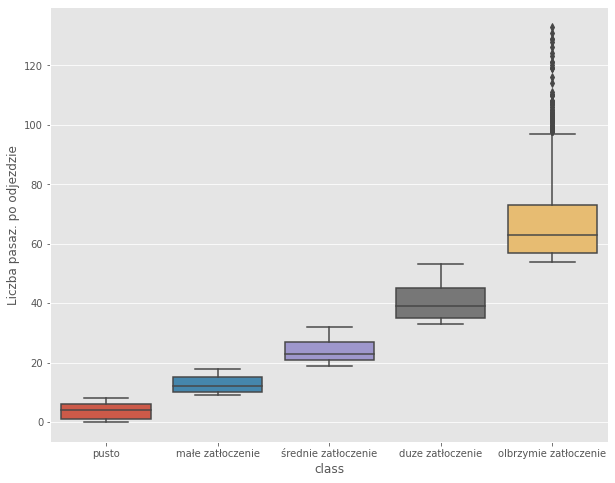

In [107]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    x='class',
    order=crowding,
    y='Liczba pasaz. po odjezdzie',
    data=df
)

In [122]:
def create_heatmap(df, corr):
    

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
dfheatmap = df['Liczba pasaz. po odjezdzie']

In [125]:
corr = df.corr()
corr

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Godzina odjazdu,Godzina odjazdu przedział
Numer taborowy,1.000000,-0.002003,0.320958,0.124254,0.123192,0.321755,-0.002678,-0.002722
Numer przystanku,-0.002003,1.000000,-0.030895,0.013882,0.024542,-0.028010,-0.000627,-0.000607
Liczba pasaz. przed,0.320958,-0.030895,1.000000,0.374577,0.146987,0.944015,-0.049583,-0.049621
Liczba wysiadających pasaz.,0.124254,0.013882,0.374577,1.000000,0.146362,0.160806,-0.035205,-0.035178
Liczba wsiadajacych pasaz.,0.123192,0.024542,0.146987,0.146362,1.000000,0.370362,-0.049363,-0.049336
Liczba pasaz. po odjezdzie,0.321755,-0.028010,0.944015,0.160806,0.370362,1.000000,-0.053566,-0.053604
Godzina odjazdu,-0.002678,-0.000627,-0.049583,-0.035205,-0.049363,-0.053566,1.000000,0.999908
Godzina odjazdu przedział,-0.002722,-0.000607,-0.049621,-0.035178,-0.049336,-0.053604,0.999908,1.000000


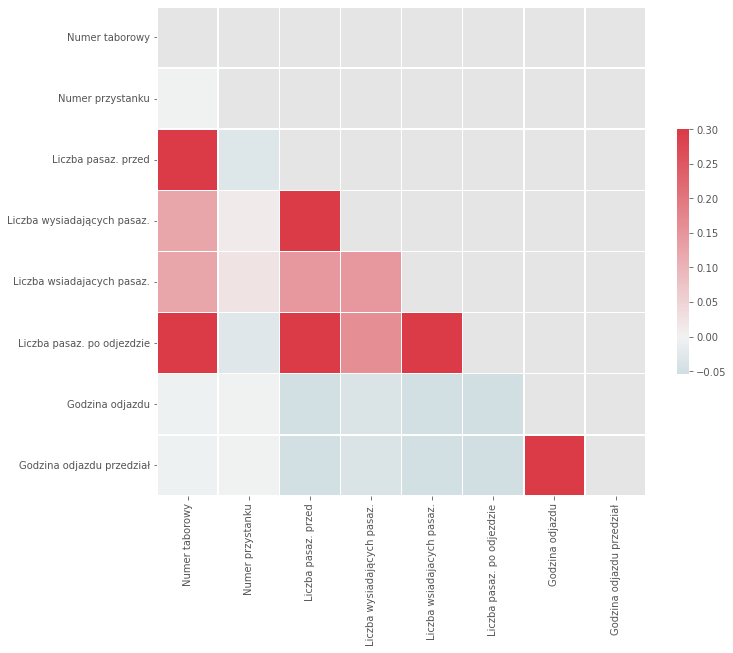

In [123]:
create_heatmap(df,corr)

# 7. SVN


In [16]:
from sklearn import svm
import seaborn as sns

In [17]:
dat = df[["Liczba pasaz. po odjezdzie", "Godzina odjazdu"]]

167342

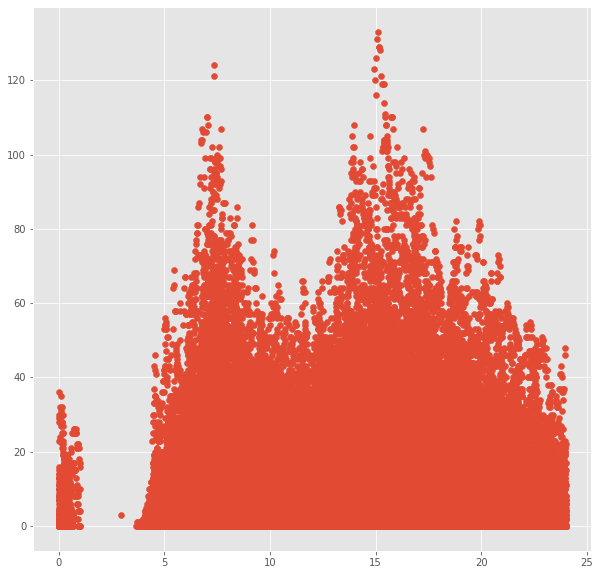

In [30]:
plt.figure(figsize=(10, 10))
plt.scatter(x = dat["Godzina odjazdu"], y = dat['Liczba pasaz. po odjezdzie'])
plt.show()

In [97]:
def show_me_outliers(data, nu, kernel, gamma):
    X = data
    w = len(nu)*len(gamma)*len(kernel)
    ins_outs = np.zeros((w, 2))
    k=0
    for i in range(len(nu)):
        for j in range(len(kernel)):
            for z in range(len(gamma)):
                clf2 = svm.OneClassSVM(nu = nu[i], gamma = gamma[z], kernel = kernel[j])
                #clf.fit(X, y)
                #1 for inliers, -1 for outliers
                # print(X)
                fit_predict = clf2.fit_predict(X)

                data['nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j])] = pd.DataFrame(fit_predict)
                hue_col = str('nu='+str(nu[i])+', gamma='+str(gamma[z])+', ' + str(kernel[j]))
                plt.figure(hue_col, figsize = (10,10))
                sns.scatterplot(data = data, x = 'Godzina odjazdu', y = 'Liczba pasaz. po odjezdzie' , hue = hue_col)

                X = X.fillna(0)
                print(X)
                fit_predict = clf2.fit_predict(X)
                # fit_predict = pd.DataFrame(fit_predict).fillna(0)

                stats = np.unique(fit_predict, return_counts=True)
                print('stats', stats)
                print('stats[1][0]',stats[1][0])
                ins_outs[k,0] = stats[1][0]
                print('stats[1][1]',stats[1][1])
                ins_outs[k,1] = stats[1][1]
                
                k+=1

    ins_outs = pd.DataFrame(ins_outs, columns = stats[0], index = data.columns.values[-w:]).astype(int)         
    return data, ins_outs

        Liczba pasaz. po odjezdzie  Godzina odjazdu  nu=0.1, gamma=0.1, linear
0                                1         5.183333                       -1.0
1                                1         5.183333                       -1.0
2                                3         5.200000                       -1.0
3                                3         5.216667                       -1.0
4                                3         5.233333                       -1.0
...                            ...              ...                        ...
177541                          13        17.016667                        0.0
177542                           5        17.166667                        0.0
177543                           2        17.183333                        0.0
177544                           1        17.200000                        0.0
177545                           0        17.216667                        0.0

[167342 rows x 3 columns]
stats (array([-1,  1]), a

,-1,1
"nu=0.1, gamma=0.1, linear",16737,150605


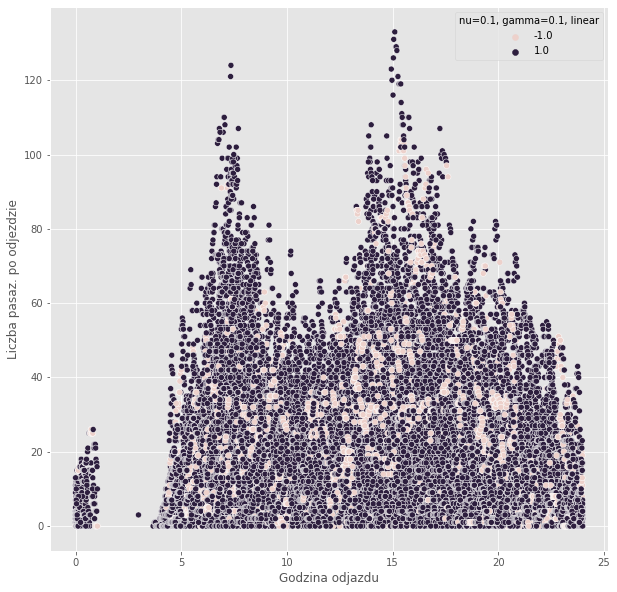

In [102]:
nu = [0.1]
gamma = [0.1]
kernel = ['linear']
#‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’, default = 'rbf'
df2 = dat
df2, ins_out = show_me_outliers(data = df2, nu = nu, kernel = kernel, gamma = gamma)
ins_out

In [92]:
ins_out

,-1,1
"nu=0.1, gamma=0.1, linear",1,4


In [33]:
dat[:1000]

,Liczba pasaz. po odjezdzie,Godzina odjazdu
0,1,5.183333
1,1,5.183333
2,3,5.200000
3,3,5.216667
4,3,5.233333
...,...,...
997,16,16.716667
998,19,16.750000
999,22,16.766667
1000,22,16.783333


[   Liczba pasaz. po odjezdzie  Godzina odjazdu
 0                           1         5.183333
 1                           1         5.183333
 2                           3         5.200000
 3                           3         5.216667
 4                           3         5.233333,
 Empty DataFrame
 Columns: [Liczba pasaz. po odjezdzie, Godzina odjazdu]
 Index: []]